In [80]:
#Celda 1
import sys, subprocess
print("Usando Python:", sys.executable)
subprocess.check_call([sys.executable, "-m", "pip", "install", "-U", "pandas"])
import pandas as pd
print("pandas OK:", pd.__version__)
#Solo ejecutar una vez

Usando Python: /opt/homebrew/opt/python@3.11/bin/python3.11
pandas OK: 2.3.1



[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: /opt/homebrew/opt/python@3.11/bin/python3.11 -m pip install --upgrade pip


In [81]:
#Celda 2 crea Datalog_Filtered_log_R.csv
import pandas as pd  # Importa Pandas para manejar datos tabulares / Imports Pandas for tabular data

# Solo modificar: nombres de archivo de entrada/salida y umbral / Only edit: input/output filenames and threshold
input_csv_filename = 'Datalog_merged_log_R.csv'
output_csv_filename = 'Datalog_Filtered_log_R.csv'
# Umbral para filtrar lecturas erróneas (p. ej., -127°C) / Threshold to drop erroneous readings (e.g., -127°C)
temperature_threshold = -120.0

try:
    # pd.read_csv(...) carga el CSV en un DataFrame / loads CSV into a DataFrame
    df = pd.read_csv(input_csv_filename)
    # len(df) entrega número de filas; f-string formatea mensaje / row count; f-string formats message
    print(f"Successfully loaded '{input_csv_filename}'. Found {len(df)} rows.")
    
    # df.columns lista nombres de columnas; list comprehension filtra las que inician con 'S' (sensores)
    # df.columns lists column names; list comprehension keeps those starting with 'S' (sensors)
    sensor_columns = [col for col in df.columns if col.startswith('S')]
    
    # pd.to_numeric(..., errors='coerce') convierte a numérico; valores inválidos → NaN
    # converts to numeric; invalid strings become NaN
    for col in sensor_columns:
        df[col] = pd.to_numeric(df[col], errors='coerce')

    # df[sensor_columns] < threshold: comparación vectorizada → DataFrame booleano por celda
    # any(axis=1): True si cualquier sensor de la fila está por debajo del umbral
    # vectorized comparison -> boolean DF; any across columns marks rows to remove
    mask_to_remove = (df[sensor_columns] < temperature_threshold).any(axis=1)

    # ~ invierte el booleano; df[mask] aplica indexación booleana para quedarnos con filas válidas
    # boolean indexing to keep rows NOT flagged for removal
    filtered_df = df[~mask_to_remove]
    
    # mask_to_remove.sum() cuenta True (filas removidas); len(filtered_df) filas restantes
    # count removed rows; remaining rows
    print(f"Removed {mask_to_remove.sum()} rows with temperatures below {temperature_threshold}°C.")
    print(f"{len(filtered_df)} rows remaining.")

    if not filtered_df.empty:  # .empty True si no hay filas / True if DF has no rows
        # to_csv(..., index=False) guarda CSV sin columna índice de Pandas
        # save CSV without Pandas index column
        filtered_df.to_csv(output_csv_filename, index=False)
        print(f"Datos filtrados guardados como: '{output_csv_filename}'.")
    else:
        print("No data remained after filtering. Output file was not created.")

# Captura archivo no encontrado / Catch missing input file
except FileNotFoundError:
    print(f"Error: The file '{input_csv_filename}' was not found.")
# Captura cualquier otro error / Catch any other unexpected error
except Exception as e:
    print(f"An unexpected error occurred: {e}")


Successfully loaded 'Datalog_merged_log_R.csv'. Found 6950 rows.
Removed 0 rows with temperatures below -120.0°C.
6950 rows remaining.
Datos filtrados guardados como: 'Datalog_Filtered_log_R.csv'.


In [82]:
#Celda 3
import sys, subprocess
print("Kernel Python:", sys.executable)  # verifica qué intérprete usa el notebook
subprocess.check_call([sys.executable, "-m", "pip", "install", "-U", "seaborn"])
import seaborn as sns
print("Seaborn OK:", sns.__version__)


Kernel Python: /opt/homebrew/opt/python@3.11/bin/python3.11
Seaborn OK: 0.13.2



[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: /opt/homebrew/opt/python@3.11/bin/python3.11 -m pip install --upgrade pip


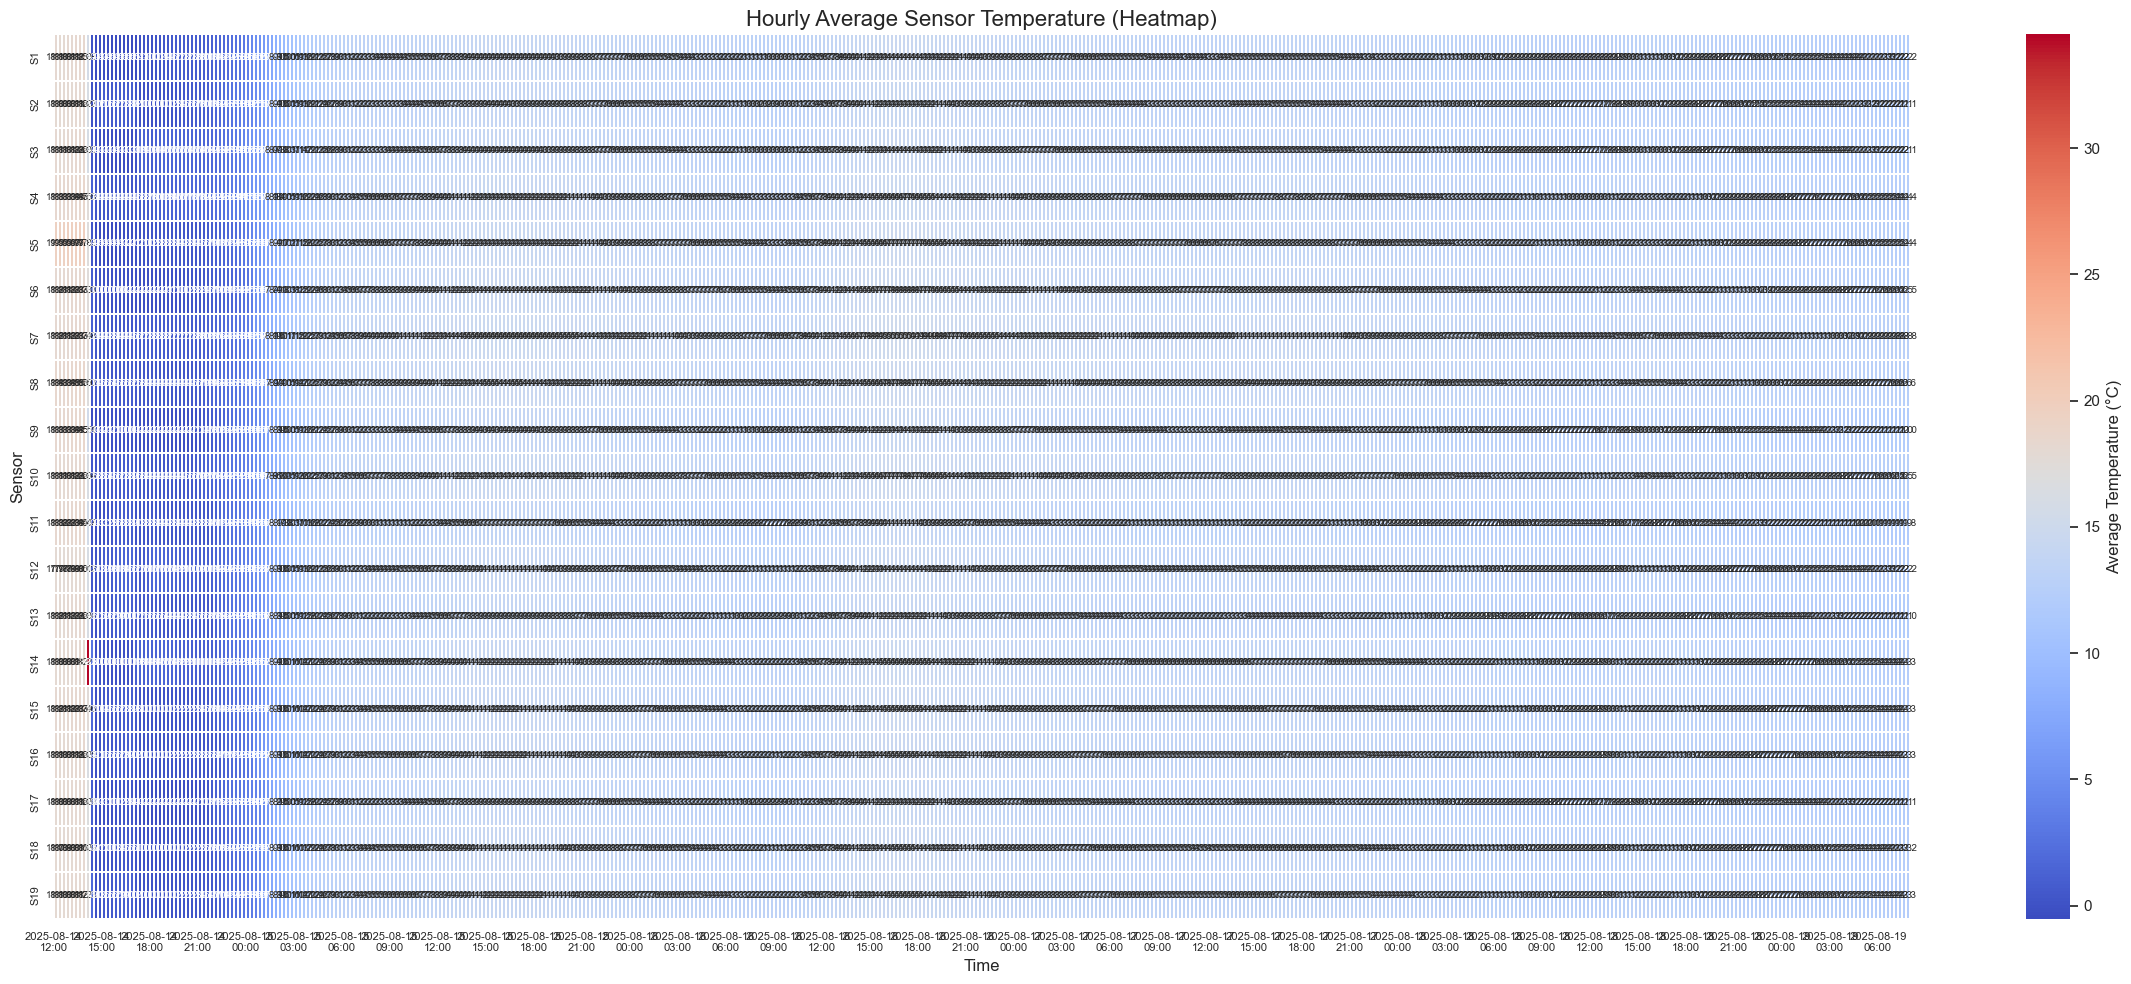

In [83]:
#Celda para crear figura, 1
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# ==== Parámetros ajustables ====
RESAMPLE_RULE = '15Min'      # prueba '20Min', '30Min' o '1H' para menos columnas
ANNOT_EVERY_N_COLS = 4       # anota solo 1 de cada N columnas (sube este número si sigue denso)
XTICK_EVERY_N = 12           # etiqueta 1 de cada N columnas en el eje X
CELL_TEXT_SIZE = 7           # tamaño de texto dentro de las celdas
TICK_FONT_SIZE = 8           # tamaño de las etiquetas de ejes
FIGSIZE = (24, 10)           # tamaño de figura
# ==============================

input_csv_filename = 'Datalog_Filtered_log_R.csv'

df = pd.read_csv(input_csv_filename)
df['Timestamp'] = pd.to_datetime(df['Date'] + ' ' + df['Time'])
df.set_index('Timestamp', inplace=True)

sensor_columns = sorted([c for c in df.columns if c.startswith('S')], key=lambda x: int(x[1:]))
for c in sensor_columns:
    df[c] = pd.to_numeric(df[c], errors='coerce')

# Resample
resampled_df = df[sensor_columns].resample(RESAMPLE_RULE).mean()
heatmap_data = resampled_df.transpose()  # filas: sensores, columnas: tiempo

# ---- Anotar solo algunas celdas ----
# Creamos una matriz de etiquetas (strings) y vaciamos la mayoría
labels = heatmap_data.round(1).astype(str)
mask = np.ones_like(labels, dtype=bool)
ANNOT_EVERY_N_COLS = 1 # Para que salgan todas las temperaturas en todas las celdas
mask[:, ::ANNOT_EVERY_N_COLS] = False    # dejamos visibles solo cada N columnas
labels = labels.where(~mask, other='')   # el resto, vacío
# ------------------------------------

plt.figure(figsize=FIGSIZE)
ax = sns.heatmap(
    heatmap_data,
    cmap='coolwarm',
    linewidths=.3,
    cbar_kws={'label': 'Average Temperature (°C)'},
    annot=labels,       # pasamos nuestras etiquetas (con huecos)
    fmt='',             # ya son strings; no formatear
    annot_kws={'size': CELL_TEXT_SIZE}
)

# Menos etiquetas en X
cols = heatmap_data.columns
tick_positions = np.arange(0, len(cols), XTICK_EVERY_N)
tick_labels = [cols[i].strftime('%Y-%m-%d\n%H:%M') for i in tick_positions]
ax.set_xticks(tick_positions)
ax.set_xticklabels(tick_labels, rotation=0, ha='center')

# Tamaño de fuentes en ejes
ax.tick_params(axis='x', labelsize=TICK_FONT_SIZE)
ax.tick_params(axis='y', labelsize=TICK_FONT_SIZE)

ax.set_title('Hourly Average Sensor Temperature (Heatmap)', fontsize=16)
ax.set_xlabel('Time', fontsize=12)
ax.set_ylabel('Sensor', fontsize=12)

plt.tight_layout()
plt.savefig('Heatmap.png', dpi=300, bbox_inches='tight')
plt.show()


/var/folders/57/0s4gzsns02nd_2_xs6b7h44r0000gn/T/ipykernel_2851/532327509.py:32: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  resampled_df = df[sensor_columns].resample(RESAMPLE_RULE).mean()


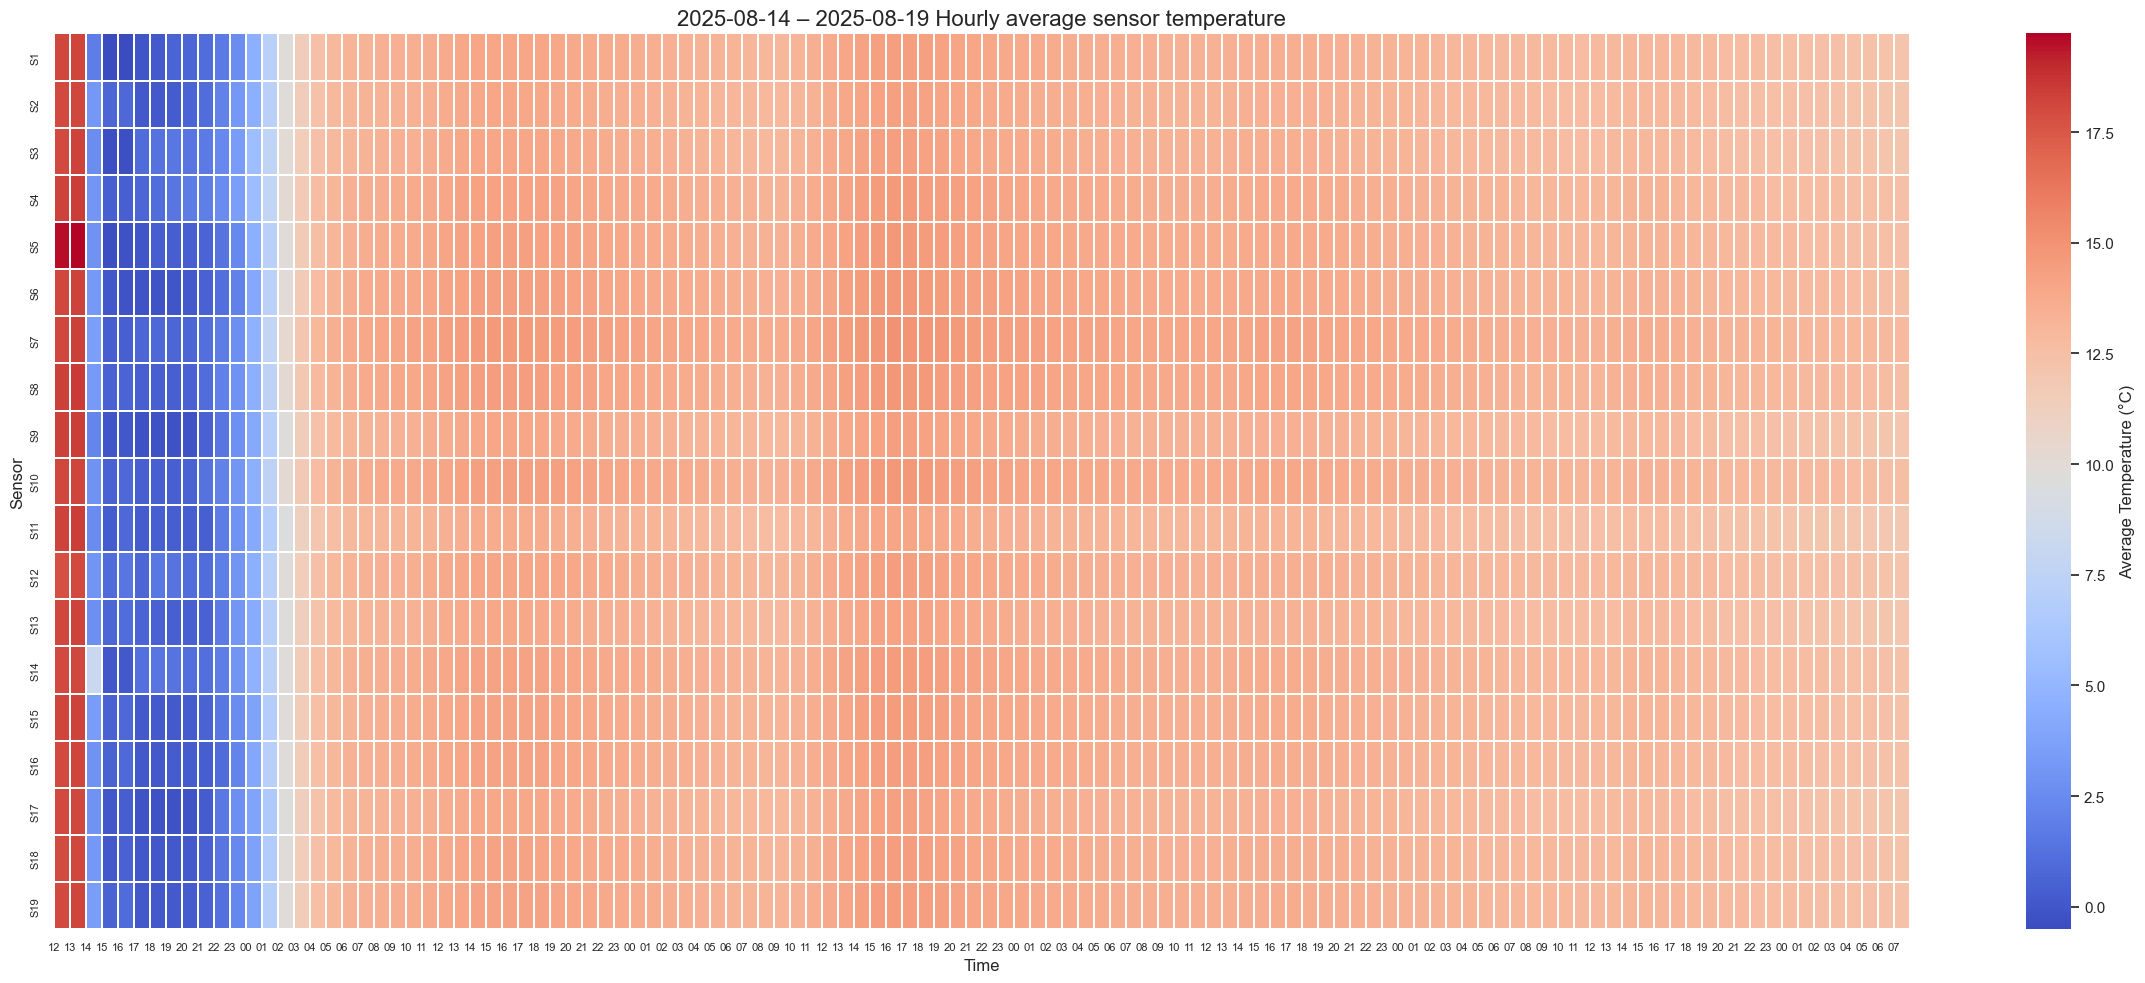

In [84]:
#Celda para crear figura, 2
#Codigo de Heat map por día
import pandas as pd  # Manejo de datos tabulares (DataFrames) / Tabular data handling (DataFrames)
import numpy as np   # Utilidades numéricas y de arreglos / Numerical and array utilities
import seaborn as sns  # Gráficos estadísticos de alto nivel / High-level statistical plotting
import matplotlib.pyplot as plt  # API base de gráficos / Base plotting API

# ==== Parámetros ajustables ====
RESAMPLE_RULE = '1H'      # Regla de remuestreo temporal (p. ej., '20Min','30Min','1H') / Time resample rule
ANNOT_EVERY_N_COLS = 4       # Anotar 1 de cada N columnas / Annotate 1 of every N columns
XTICK_EVERY_N = 12           # (no se usa en esta versión con horas exactas) / (unused here; hourly ticks used instead)
CELL_TEXT_SIZE = 7           # Tamaño de texto dentro de celdas / In-cell text size
TICK_FONT_SIZE = 8           # Tamaño de fuente de marcas de eje / Axis tick font size
FIGSIZE = (24, 10)           # Tamaño de figura (ancho, alto) / Figure size (width, height)
# ==============================

input_csv_filename = 'Datalog_Filtered_log_R.csv'  # Archivo CSV de entrada / Input CSV file

df = pd.read_csv(input_csv_filename)  # Carga CSV en DataFrame / Load CSV into DataFrame
df['Timestamp'] = pd.to_datetime(df['Date'] + ' ' + df['Time'])  # Convierte Date+Time a datetime / Parse Date+Time to datetime
df.set_index('Timestamp', inplace=True)  # Usa Timestamp como índice temporal / Use Timestamp as time index

# Ordena columnas de sensores S1..Sn numéricamente / Sort sensor columns numerically
sensor_columns = sorted([c for c in df.columns if c.startswith('S')], key=lambda x: int(x[1:]))

# Asegura tipo numérico (valores no válidos → NaN) / Ensure numeric dtype (invalid values → NaN)
for c in sensor_columns:
    df[c] = pd.to_numeric(df[c], errors='coerce')

# Resample
# Agrupa por intervalos de tiempo y promedia / Time-bucket by RESAMPLE_RULE and average
resampled_df = df[sensor_columns].resample(RESAMPLE_RULE).mean()

# Transpone para que filas sean sensores y columnas sean tiempo / Transpose: rows=sensors, cols=time
heatmap_data = resampled_df.transpose()

# ---- Anotar solo algunas celdas ----
# Redondea a 1 decimal y convierte a string para anotaciones / Round to 1 decimal and stringify for annotations
labels = heatmap_data.round(1).astype(str)

# Máscara booleana del mismo tamaño; True = ocultar etiqueta / Boolean mask same shape; True = hide label
mask = np.ones_like(labels, dtype=bool)

ANNOT_EVERY_N_COLS = 1  # Sobrescribe para anotar todas las celdas / Override to annotate every cell
mask[:, ::ANNOT_EVERY_N_COLS] = False  # Deja visibles cada N columnas (aquí, todas) / Unmask every Nth column (here, all)

# Mantiene texto donde ~mask es True, resto vacío / Keep text where ~mask True, else empty
labels = labels.where(~mask, other='')
# ------------------------------------

plt.figure(figsize=FIGSIZE)  # Crea figura con tamaño dado / Create figure with given size

# Dibuja mapa de calor / Draw heatmap
ax = sns.heatmap(
    heatmap_data,                 # Matriz de datos / Data matrix
    cmap='coolwarm',              # Paleta de color / Color palette
    linewidths=.3,                # Líneas de cuadrícula / Grid line width
    cbar_kws={'label': 'Average Temperature (°C)'},  # Etiqueta de colorbar / Colorbar label
    annot=False,                 # Texto dentro de celdas (original: labels) / Cell annotations
    fmt='',                       # Sin formato adicional (ya string) / No format (strings already)
    annot_kws={'size': CELL_TEXT_SIZE}  # Tamaño de anotaciones / Annotation font size
)

# ----- Etiquetas en X: solo hora, cada 1 h -----
cols = heatmap_data.columns  # DatetimeIndex de columnas / DatetimeIndex of columns
# Posiciones donde los minutos son 00 (cada hora exacta) / Positions at exact hours (minute==0)
hourly_positions = [i for i, ts in enumerate(cols) if ts.minute == 0]
# Etiquetas solo con la hora en 00..23 / Labels showing hour only (00..23)
hourly_labels = [cols[i].strftime('%H') for i in hourly_positions]
ax.set_xticks(hourly_positions)                 # Fija posiciones de ticks / Set tick positions
ax.set_xticklabels(hourly_labels, rotation=0, ha='center')  # Fija etiquetas / Set tick labels
# -----------------------------------------------

# Ajusta tamaño de fuente de los ticks / Adjust tick font size
ax.tick_params(axis='x', labelsize=TICK_FONT_SIZE)
ax.tick_params(axis='y', labelsize=TICK_FONT_SIZE)

# ----- Título con fecha(s) -----
# Normaliza a fecha (sin hora) para obtener rango de días / Normalize to date (drop time) to get day range
days = cols.normalize()
dmin, dmax = days.min(), days.max()
# Si hay un día: YYYY-MM-DD; si hay rango: YYYY-MM-DD – YYYY-MM-DD / Single day vs date range
title_date = dmin.strftime('%Y-%m-%d') if dmin == dmax else f'{dmin.strftime("%Y-%m-%d")} – {dmax.strftime("%Y-%m-%d")}'
ax.set_title(f'{title_date} Hourly average sensor temperature', fontsize=16)  # Título / Title
# --------------------------------

ax.set_xlabel('Time', fontsize=12)    # Etiqueta eje X / X-axis label
ax.set_ylabel('Sensor', fontsize=12)  # Etiqueta eje Y / Y-axis label

plt.tight_layout()  # Ajusta layout para evitar recortes / Adjust layout to avoid clipping
plt.savefig('Heatmap.png', dpi=300, bbox_inches='tight')  # Guarda imagen en alta resolución / Save high-res image
plt.show()  # Muestra la figura / Show figure


/var/folders/57/0s4gzsns02nd_2_xs6b7h44r0000gn/T/ipykernel_2851/332561904.py:79: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  resampled_df = df[sensor_columns].resample(RESAMPLE_RULE).mean()


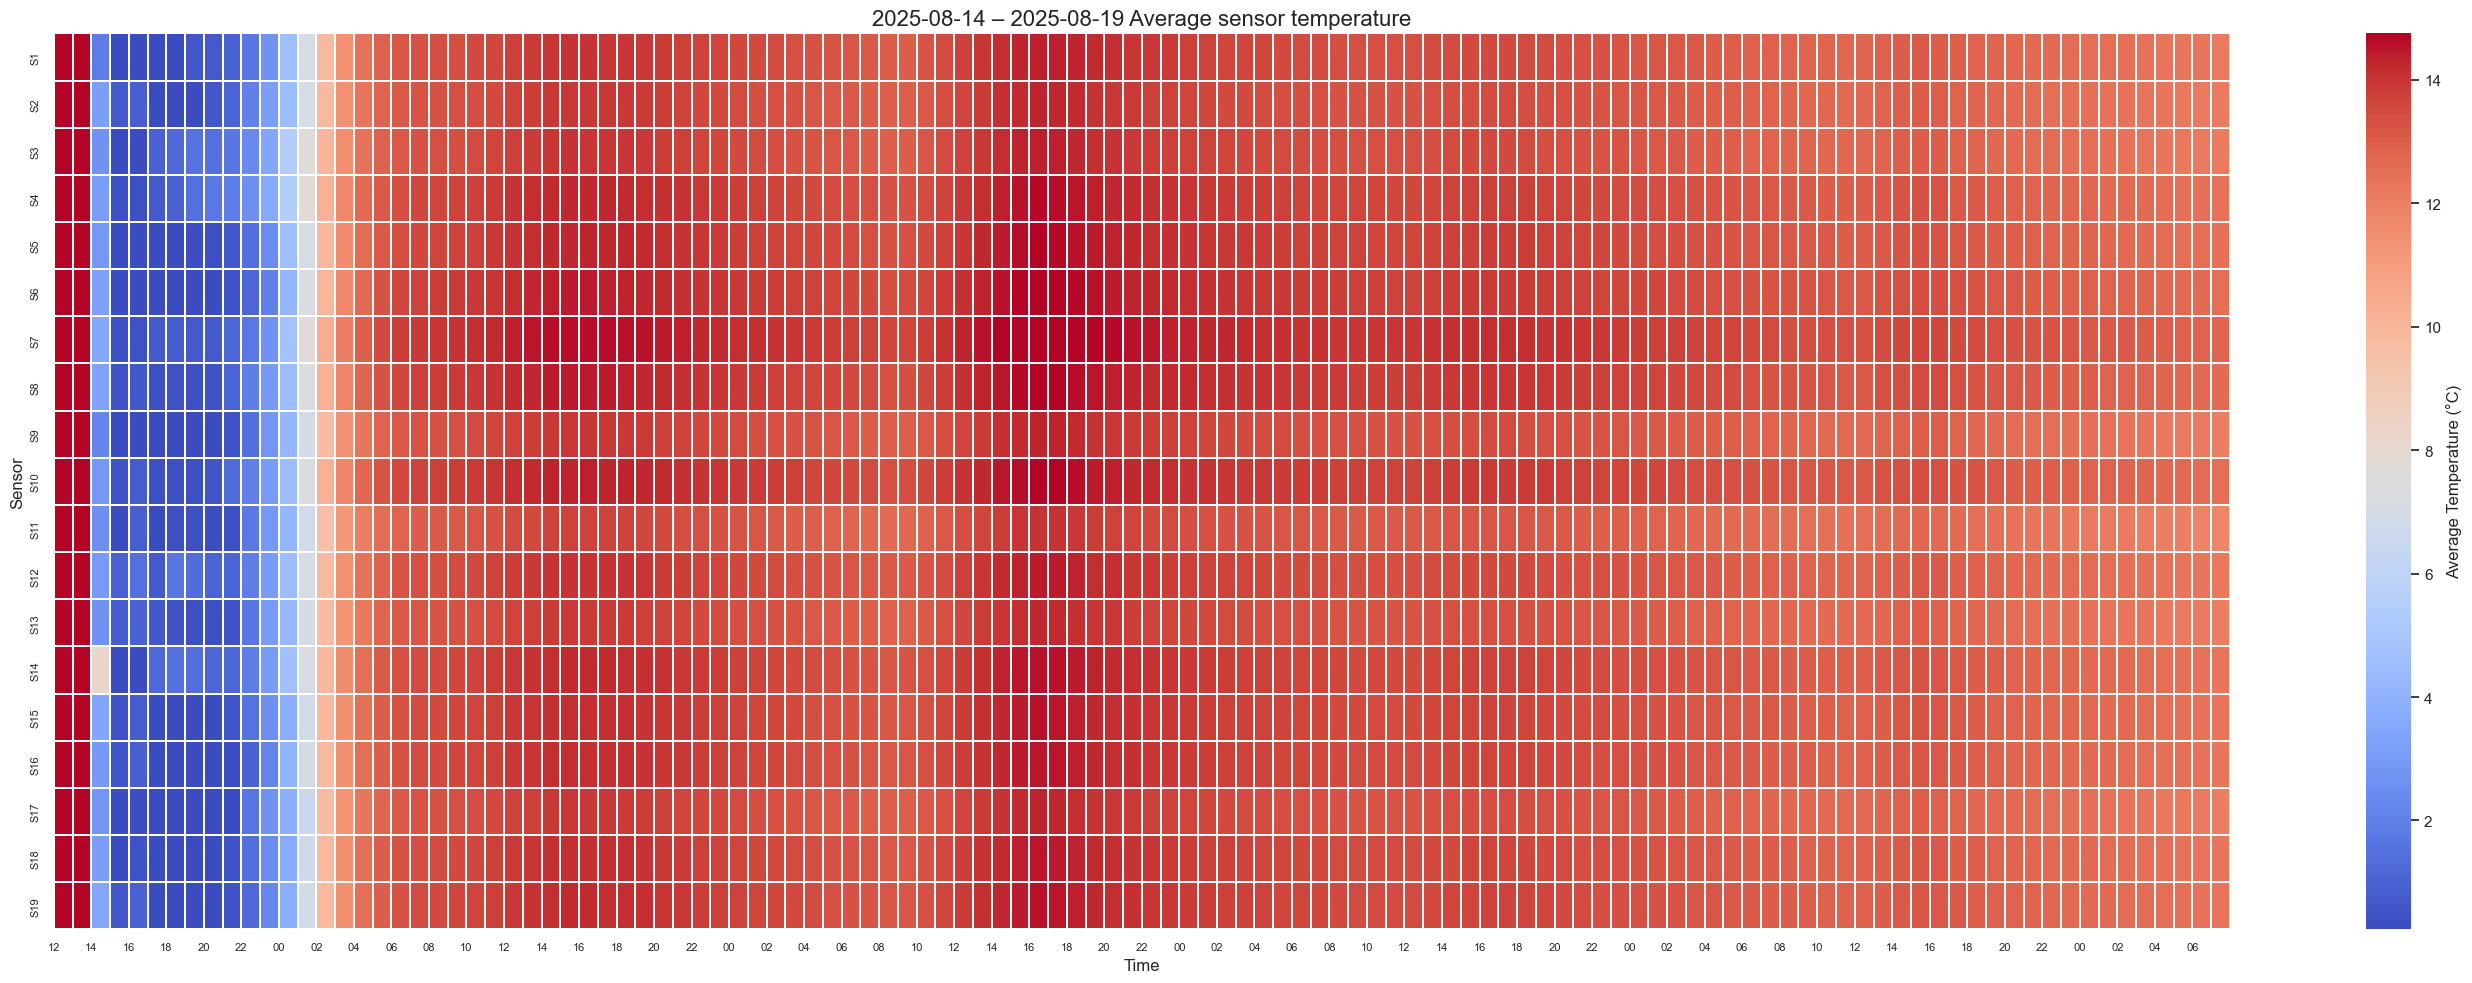

In [85]:
# Celda — Heatmap por día (versión completa y configurable)
"""Qué incluye (todo activable por parámetros)
Menos columnas: RESAMPLE_RULE='1H' y opción de SUBSAMPLE_EVERY.
Anotaciones: desactivadas por defecto (ANNOTATE=False) o raleadas cada ANNOT_EVERY_N_COLS.
Foco horario: BETWEEN_TIME=('10:00','22:00') si lo quieres.
Figura ancha y ticks cada 2 h (FIGSIZE, XTICK_EVERY_HOURS).
Small multiples: PER_DAY_FIGS=True crea un PNG por día (con PER_DAY_RESAMPLE independiente).
Estandarización (z-score): STANDARDIZE=True para resaltar anomalías (con center=0).
Clipping: por cuantiles (CLIP_BY_QUANTILES) o rangos fijos (VMIN_FIXED/VMAX_FIXED).
Suavizado: SMOOTH_WINDOW='45Min' si necesitas “planchar” ruido.
Limitar sensores: MAX_SENSOR=19 para evitar S20.
"""
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# ============== PARÁMETROS AJUSTABLES ==============
INPUT_CSV = 'Datalog_Filtered_log_R.csv'  # archivo de entrada

# 1) Menos columnas: subir intervalo temporal o subsamplear
RESAMPLE_RULE = '1H'      # '15Min', '30Min', '1H'
SUBSAMPLE_EVERY = None     # None o entero (p.ej., 4 para 1 de cada 4 columnas)

# 2) Anotaciones dentro de celdas
ANNOTATE = False           # True/False
ANNOT_EVERY_N_COLS = 6     # Si ANNOTATE=True, anota 1 de cada N columnas
CELL_TEXT_SIZE = 7

# 3) Foco horario (filtra antes del resample)
BETWEEN_TIME = None        # None o ('10:00', '22:00')

# 4) Figura y ticks en X
FIGSIZE = (28, 10)         # más ancho para rangos largos
XTICK_EVERY_HOURS = 2      # ticks cada N horas (2 recomendado con 1H)
TICK_FONT_SIZE = 8

# 5) Small multiples: 1 heatmap por día además del global
PER_DAY_FIGS = True        # genera Heatmap_YYYY-MM-DD.png por cada día
PER_DAY_RESAMPLE = '30Min' # resolución por día ('30Min' o '1H')
PER_DAY_FIGSIZE = (18, 8)

# 6) Estandarizar por sensor (z-score) para ver anomalías
STANDARDIZE = False        # True → muestra z-score (center=0)

# 7) Clipping de rango de color (evitar que outliers “aplanen” todo)
CLIP_BY_QUANTILES = (0.02, 0.98)  # None o (q_low, q_high). Ej.: (0.02, 0.98)
# O definir fijo (se ignora si usas quantiles):
VMIN_FIXED = None          # Ej. 10
VMAX_FIXED = None          # Ej. 40

# 8) Suavizado (media móvil) tras el resample
SMOOTH_WINDOW = None       # None o ventana tipo '45Min', '2H', etc.
# 9) Limitar sensores (ej. S1..S19)
MAX_SENSOR = 19            # None para no limitar, o un entero (19 recomendado)
# ===================================================


# ============== CARGA Y PREPARACIÓN ==============
df = pd.read_csv(INPUT_CSV)
df['Timestamp'] = pd.to_datetime(df['Date'] + ' ' + df['Time'])
df.set_index('Timestamp', inplace=True)

# Detectar columnas de sensores y ordenarlas
sensor_columns = sorted([c for c in df.columns if c.startswith('S')], key=lambda x: int(x[1:]))
if MAX_SENSOR is not None:
    sensor_columns = [c for c in sensor_columns if int(c[1:]) <= MAX_SENSOR]

# Coerción a numérico
for c in sensor_columns:
    df[c] = pd.to_numeric(df[c], errors='coerce')

# Foco horario
if BETWEEN_TIME is not None:
    start_t, end_t = BETWEEN_TIME
    df = df.between_time(start_t, end_t)

# ============== RESAMPLE Y (OPCIONAL) SUAVIZADO ==============
resampled_df = df[sensor_columns].resample(RESAMPLE_RULE).mean()

if SMOOTH_WINDOW:
    # Suavizado temporal (rolling con ventana basada en tiempo)
    resampled_df = resampled_df.rolling(SMOOTH_WINDOW, min_periods=1).mean()

# Matriz para heatmap (filas = sensores, columnas = tiempo)
heatmap_data = resampled_df.transpose()

# (Opcional) Subsamplear columnas si todavía hay muchas
if SUBSAMPLE_EVERY and SUBSAMPLE_EVERY > 1:
    heatmap_data = heatmap_data.iloc[:, ::SUBSAMPLE_EVERY]

# ============== ANOTACIONES ==============
if ANNOTATE:
    labels = heatmap_data.round(1).astype(str)
    mask = np.ones_like(labels, dtype=bool)
    mask[:, ::max(1, ANNOT_EVERY_N_COLS)] = False
    labels = labels.where(~mask, other='')
else:
    labels = None

# ============== CLIPPING Y/O ESTANDARIZACIÓN ==============
vmin, vmax, center = None, None, None

if STANDARDIZE:
    # z-score por sensor (fila)
    hm = heatmap_data
    mu = hm.mean(axis=1)
    sigma = hm.std(axis=1).replace(0, np.nan)
    heatmap_plot = (hm - mu.values[:, None]) / sigma.values[:, None]
    center = 0
else:
    heatmap_plot = heatmap_data

# Clipping por quantiles o fijo
if not STANDARDIZE:  # en z-score, el rango suele centrarse en 0
    if CLIP_BY_QUANTILES:
        q_low, q_high = CLIP_BY_QUANTILES
        # Calcula vmin/vmax a partir de todos los datos (flatten ignorando NaNs)
        flat = heatmap_plot.to_numpy().ravel()
        flat = flat[~np.isnan(flat)]
        if flat.size > 0:
            vmin = np.quantile(flat, q_low)
            vmax = np.quantile(flat, q_high)
    if VMIN_FIXED is not None:
        vmin = VMIN_FIXED
    if VMAX_FIXED is not None:
        vmax = VMAX_FIXED

# ============== PLOTEO GLOBAL ==============
sns.set(context='notebook')
plt.figure(figsize=FIGSIZE)

ax = sns.heatmap(
    heatmap_plot,
    cmap='coolwarm',
    linewidths=.3,
    cbar_kws={'label': 'z-score' if STANDARDIZE else 'Average Temperature (°C)'},
    annot=ANNOTATE if labels is not None else False,
    fmt='',
    annot_kws={'size': CELL_TEXT_SIZE},
    vmin=vmin,
    vmax=vmax,
    center=center
)

# Ticks en X cada N horas
cols = heatmap_plot.columns  # DatetimeIndex
if len(cols) > 0 and isinstance(cols, pd.DatetimeIndex):
    hourly_positions = [i for i, ts in enumerate(cols) if (ts.minute == 0 and (ts.hour % max(1, XTICK_EVERY_HOURS) == 0))]
    hourly_labels = [cols[i].strftime('%H') for i in hourly_positions]
    ax.set_xticks(hourly_positions)
    ax.set_xticklabels(hourly_labels, rotation=0, ha='center')

# Etiquetas y títulos
ax.tick_params(axis='x', labelsize=TICK_FONT_SIZE)
ax.tick_params(axis='y', labelsize=TICK_FONT_SIZE)

# Título con rango de fechas
if len(cols) > 0:
    days = cols.normalize()
    dmin, dmax = days.min(), days.max()
    title_date = dmin.strftime('%Y-%m-%d') if dmin == dmax else f'{dmin.strftime("%Y-%m-%d")} – {dmax.strftime("%Y-%m-%d")}'
else:
    title_date = ''

ax.set_title(f'{title_date} Average sensor temperature' + (' (z-score)' if STANDARDIZE else ''), fontsize=16)
ax.set_xlabel('Time', fontsize=12)
ax.set_ylabel('Sensor', fontsize=12)

plt.tight_layout()
plt.savefig('Heatmap.png', dpi=300, bbox_inches='tight')
plt.show()

# ============== SMALL MULTIPLES (UNO POR DÍA) ==============
if PER_DAY_FIGS:
    # Recalcula por día antes del transpose para no arrastrar SUBSAMPLE del global
    for day, g in df.groupby(df.index.date):
        per_day = g[sensor_columns].resample(PER_DAY_RESAMPLE).mean()
        if SMOOTH_WINDOW:
            per_day = per_day.rolling(SMOOTH_WINDOW, min_periods=1).mean()
        hm = per_day.transpose()

        # (Opcional) subsample por día: aquí no lo aplicamos para más detalle
        # Estandarización por sensor si se pidió
        if STANDARDIZE:
            mu = hm.mean(axis=1)
            sigma = hm.std(axis=1).replace(0, np.nan)
            hm_plot = (hm - mu.values[:, None]) / sigma.values[:, None]
            vmin_d, vmax_d, center_d = None, None, 0
            cbar_label = 'z-score'
        else:
            hm_plot = hm
            # Clipping similar al global
            vmin_d, vmax_d, center_d = None, None, None
            if CLIP_BY_QUANTILES:
                flat = hm_plot.to_numpy().ravel()
                flat = flat[~np.isnan(flat)]
                if flat.size > 0:
                    vmin_d = np.quantile(flat, CLIP_BY_QUANTILES[0])
                    vmax_d = np.quantile(flat, CLIP_BY_QUANTILES[1])
            if VMIN_FIXED is not None:
                vmin_d = VMIN_FIXED
            if VMAX_FIXED is not None:
                vmax_d = VMAX_FIXED
            cbar_label = 'Average Temperature (°C)'

        plt.figure(figsize=PER_DAY_FIGSIZE)
        ax2 = sns.heatmap(
            hm_plot,
            cmap='coolwarm',
            linewidths=.3,
            cbar_kws={'label': cbar_label},
            annot=False,            # por día, mejor sin anotaciones
            vmin=vmin_d,
            vmax=vmax_d,
            center=center_d
        )

        # Ticks cada N horas
        cols_d = hm_plot.columns
        if len(cols_d) > 0 and isinstance(cols_d, pd.DatetimeIndex):
            pos = [i for i, ts in enumerate(cols_d) if (ts.minute == 0 and (ts.hour % max(1, XTICK_EVERY_HOURS) == 0))]
            lab = [cols_d[i].strftime('%H') for i in pos]
            ax2.set_xticks(pos)
            ax2.set_xticklabels(lab, rotation=0, ha='center')

        ax2.tick_params(axis='x', labelsize=TICK_FONT_SIZE)
        ax2.tick_params(axis='y', labelsize=TICK_FONT_SIZE)
        ax2.set_title(f'{day} Average sensor temperature' + (' (z-score)' if STANDARDIZE else ''), fontsize=14)
        ax2.set_xlabel('Time', fontsize=11)
        ax2.set_ylabel('Sensor', fontsize=11)

        plt.tight_layout()
        outname = f'Heatmap_{day}.png'
        plt.savefig(outname, dpi=300, bbox_inches='tight')
        plt.close()


/var/folders/57/0s4gzsns02nd_2_xs6b7h44r0000gn/T/ipykernel_2851/1893732533.py:79: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  resampled_df = df[sensor_columns].resample(RESAMPLE_RULE).mean()


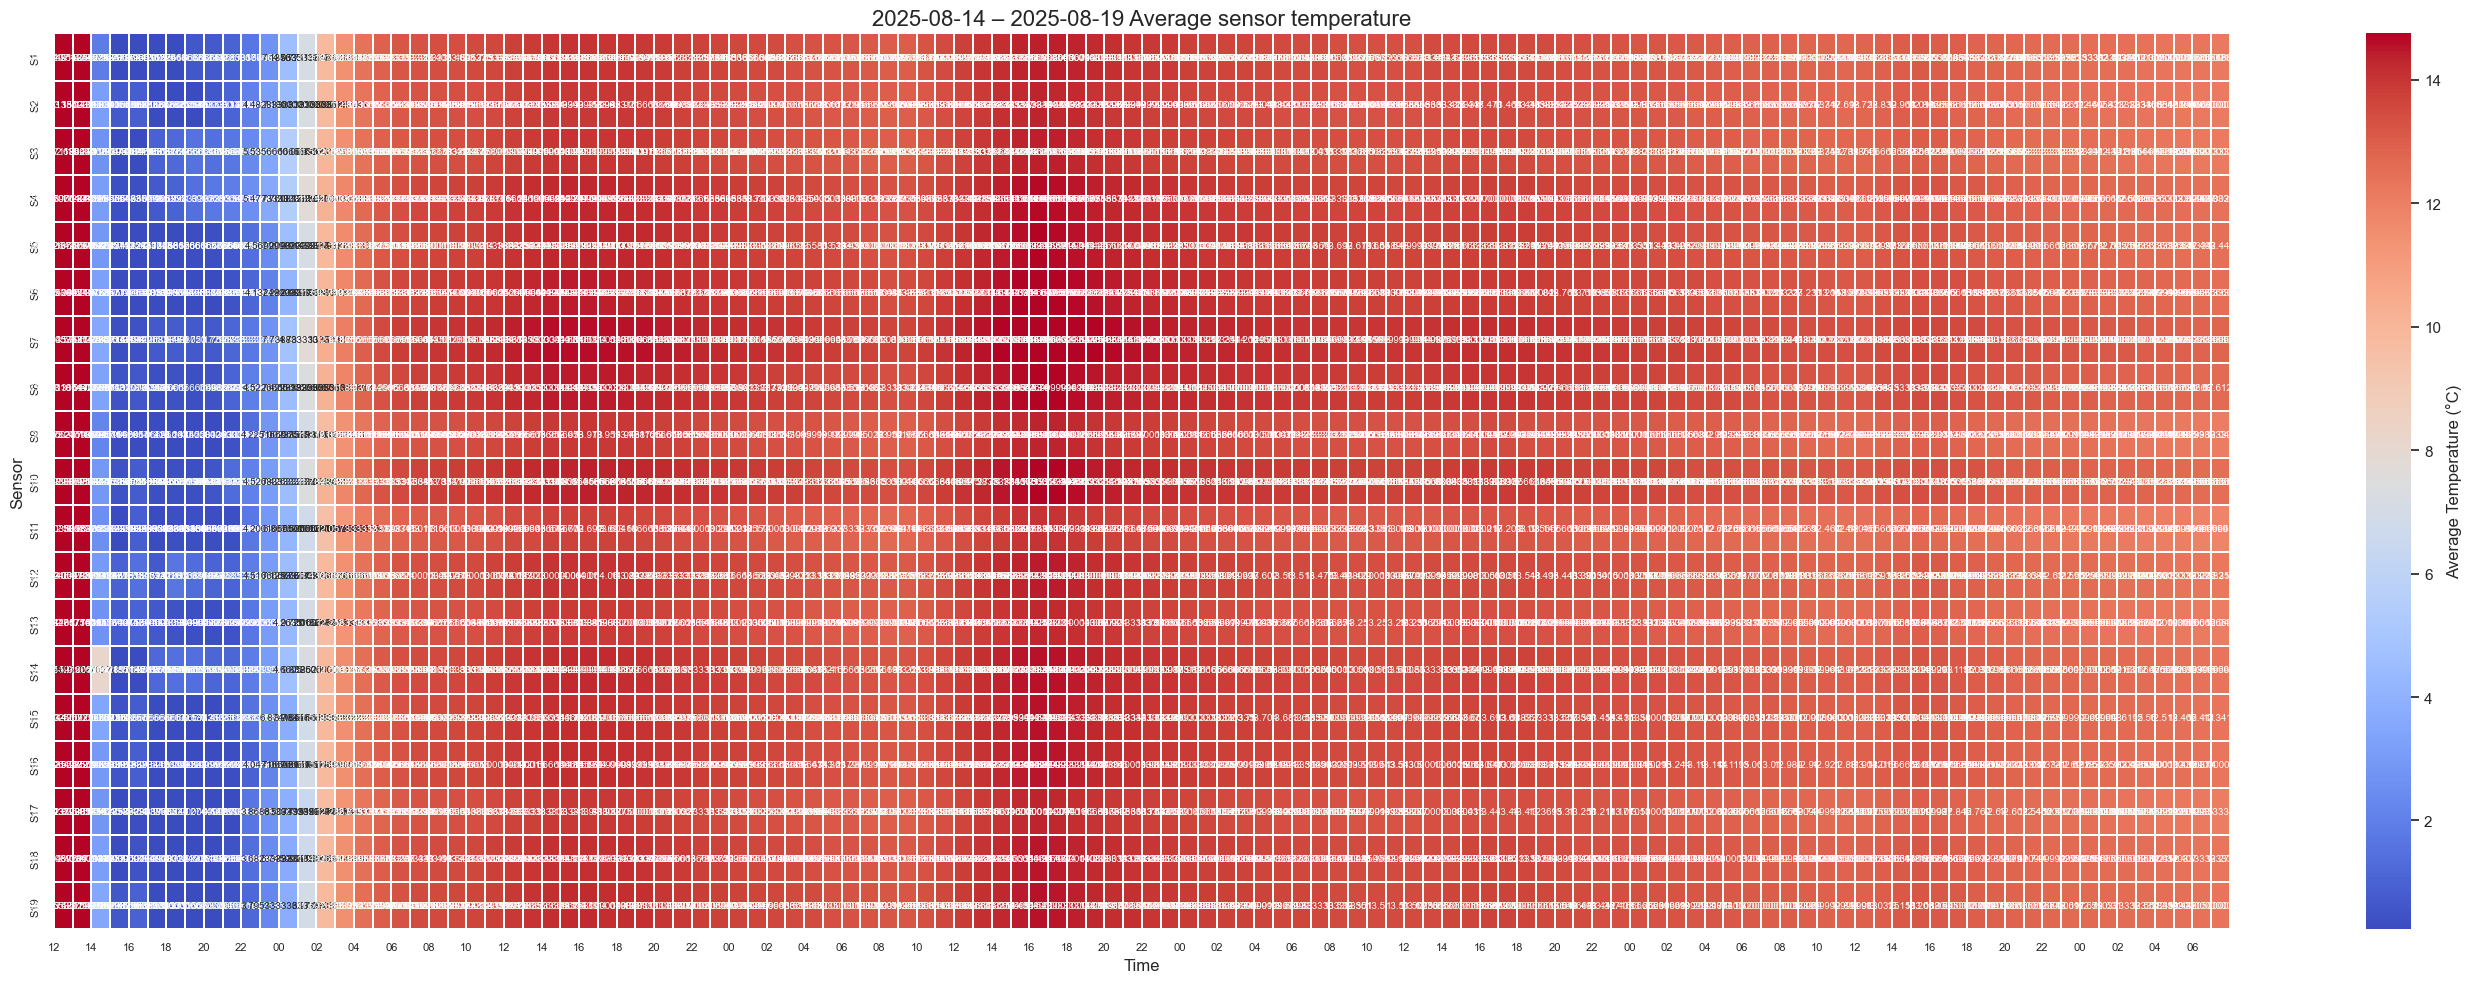

In [86]:
# Celda — Heatmap por día (versión completa con valores anotados en celdas)
"""
Notas rápidas
Ya verás el número en las celdas del gráfico principal (ANNOTATE=True).
Para reducir ruido visual, ajusta ANNOT_EVERY_N_COLS (por ejemplo 8 o 12 si el rango es muy grande).
Si activas STANDARDIZE=True, las etiquetas mostrarán z-score (no °C).
Si quieres anotar también en los gráficos por día, pon PER_DAY_ANNOTATE=True.
"""
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# ============== PARÁMETROS AJUSTABLES ==============
INPUT_CSV = 'Datalog_Filtered_log_R.csv'  # archivo de entrada

# 1) Menos columnas: subir intervalo temporal o subsamplear
RESAMPLE_RULE = '1H'      # '15Min', '30Min', '1H'
SUBSAMPLE_EVERY = None     # None o entero (p.ej., 4 = 1 de cada 4 columnas)

# 2) Anotaciones dentro de celdas (MAIN)
ANNOTATE = True            # ← ACTIVADO: mostrar valor en las celdas
ANNOT_EVERY_N_COLS = 6     # anota 1 de cada N columnas (para no saturar). Usa 1 para TODAS
CELL_TEXT_SIZE = 7
TEMP_LABEL_DECIMALS = 1    # decimales para °C
Z_LABEL_DECIMALS = 2       # decimales si STANDARDIZE=True

# 3) Foco horario (filtra antes del resample)
BETWEEN_TIME = None        # None o ('10:00', '22:00')

# 4) Figura y ticks en X
FIGSIZE = (28, 10)         # más ancho para rangos largos
XTICK_EVERY_HOURS = 2      # ticks cada N horas
TICK_FONT_SIZE = 8

# 5) Small multiples: 1 heatmap por día además del global
PER_DAY_FIGS = True        # genera Heatmap_YYYY-MM-DD.png por día
PER_DAY_RESAMPLE = '30Min' # resolución por día ('30Min' o '1H')
PER_DAY_FIGSIZE = (18, 8)
PER_DAY_ANNOTATE = False   # anotar o no en los por-día (mejor False para claridad)
PER_DAY_ANNOT_EVERY = 4    # si PER_DAY_ANNOTATE=True, 1 de cada N columnas

# 6) Estandarizar por sensor (z-score) para ver anomalías
STANDARDIZE = False        # True → heatmap en z-score (center=0) y etiquetas en z-score

# 7) Clipping de rango de color (evitar que outliers “aplanen” todo)
CLIP_BY_QUANTILES = (0.02, 0.98)  # None o (q_low, q_high)
VMIN_FIXED = None          # Ej. 10  (anula quantiles si no es None)
VMAX_FIXED = None          # Ej. 40

# 8) Suavizado (media móvil) tras el resample
SMOOTH_WINDOW = None       # None o ventana tipo '45Min', '2H', etc.

# 9) Limitar sensores (ej. S1..S19)
MAX_SENSOR = 19            # None para no limitar, o un entero (19 recomendado)
# ===================================================


# ============== CARGA Y PREPARACIÓN ==============
df = pd.read_csv(INPUT_CSV)
df['Timestamp'] = pd.to_datetime(df['Date'] + ' ' + df['Time'])
df.set_index('Timestamp', inplace=True)

# Detectar columnas de sensores y ordenarlas
sensor_columns = sorted([c for c in df.columns if c.startswith('S')], key=lambda x: int(x[1:]))
if MAX_SENSOR is not None:
    sensor_columns = [c for c in sensor_columns if int(c[1:]) <= MAX_SENSOR]

# Coerción a numérico
for c in sensor_columns:
    df[c] = pd.to_numeric(df[c], errors='coerce')

# Foco horario
if BETWEEN_TIME is not None:
    start_t, end_t = BETWEEN_TIME
    df = df.between_time(start_t, end_t)

# ============== RESAMPLE Y (OPCIONAL) SUAVIZADO ==============
resampled_df = df[sensor_columns].resample(RESAMPLE_RULE).mean()

if SMOOTH_WINDOW:
    resampled_df = resampled_df.rolling(SMOOTH_WINDOW, min_periods=1).mean()

# Matriz para heatmap (filas = sensores, columnas = tiempo)
heatmap_data = resampled_df.transpose()

# (Opcional) Subsamplear columnas si todavía hay muchas
if SUBSAMPLE_EVERY and SUBSAMPLE_EVERY > 1:
    heatmap_data = heatmap_data.iloc[:, ::SUBSAMPLE_EVERY]

# ============== ESTANDARIZACIÓN / CLIPPING ==============
if STANDARDIZE:
    # z-score por sensor (fila)
    mu = heatmap_data.mean(axis=1)
    sigma = heatmap_data.std(axis=1).replace(0, np.nan)
    heatmap_plot = (heatmap_data - mu.values[:, None]) / sigma.values[:, None]
    cbar_label = 'z-score'
    vmin = vmax = None
    center = 0
else:
    heatmap_plot = heatmap_data
    cbar_label = 'Average Temperature (°C)'
    # Clipping por quantiles
    vmin = vmax = None
    if CLIP_BY_QUANTILES:
        flat = heatmap_plot.to_numpy().ravel()
        flat = flat[~np.isnan(flat)]
        if flat.size > 0:
            vmin = np.quantile(flat, CLIP_BY_QUANTILES[0])
            vmax = np.quantile(flat, CLIP_BY_QUANTILES[1])
    # Rango fijo opcional
    if VMIN_FIXED is not None:
        vmin = VMIN_FIXED
    if VMAX_FIXED is not None:
        vmax = VMAX_FIXED
    center = None

# ============== ANOTACIONES (MAIN) ==============
if ANNOTATE:
    decimals = Z_LABEL_DECIMALS if STANDARDIZE else TEMP_LABEL_DECIMALS
    labels = heatmap_plot.round(decimals).astype(str)
    # Máscara para “ralear” anotaciones y no saturar
    step = max(1, int(ANNOT_EVERY_N_COLS))
    mask = np.ones_like(labels, dtype=bool)
    mask[:, ::step] = False            # deja visibles 1 de cada N columnas
    labels = labels.where(~mask, other='')
else:
    labels = None

# ============== PLOTEO GLOBAL ==============
sns.set(context='notebook')
plt.figure(figsize=FIGSIZE)

ax = sns.heatmap(
    heatmap_plot,
    cmap='coolwarm',
    linewidths=.3,
    cbar_kws={'label': cbar_label},
    annot=(labels is not None),
    fmt='',
    annot_kws={'size': CELL_TEXT_SIZE},
    vmin=vmin,
    vmax=vmax,
    center=center,
    # Si quisieras bordes de celdas más visibles: linecolor='white'
)

# Ticks en X cada N horas
cols = heatmap_plot.columns  # DatetimeIndex
if len(cols) > 0 and isinstance(cols, pd.DatetimeIndex):
    hourly_positions = [i for i, ts in enumerate(cols) if (ts.minute == 0 and (ts.hour % max(1, XTICK_EVERY_HOURS) == 0))]
    hourly_labels = [cols[i].strftime('%H') for i in hourly_positions]
    ax.set_xticks(hourly_positions)
    ax.set_xticklabels(hourly_labels, rotation=0, ha='center')

# Etiquetas y títulos
ax.tick_params(axis='x', labelsize=TICK_FONT_SIZE)
ax.tick_params(axis='y', labelsize=TICK_FONT_SIZE)

# Título con rango de fechas
if len(cols) > 0:
    days = cols.normalize()
    dmin, dmax = days.min(), days.max()
    title_date = dmin.strftime('%Y-%m-%d') if dmin == dmax else f'{dmin.strftime("%Y-%m-%d")} – {dmax.strftime("%Y-%m-%d")}'
else:
    title_date = ''

ax.set_title(f'{title_date} Average sensor temperature' + (' (z-score)' if STANDARDIZE else ''), fontsize=16)
ax.set_xlabel('Time', fontsize=12)
ax.set_ylabel('Sensor', fontsize=12)

plt.tight_layout()
plt.savefig('Heatmap.png', dpi=300, bbox_inches='tight')
plt.show()

# ============== SMALL MULTIPLES (UNO POR DÍA) ==============
if PER_DAY_FIGS:
    for day, g in df.groupby(df.index.date):
        per_day = g[sensor_columns].resample(PER_DAY_RESAMPLE).mean()
        if SMOOTH_WINDOW:
            per_day = per_day.rolling(SMOOTH_WINDOW, min_periods=1).mean()
        hm = per_day.transpose()

        # Estandarización opcional por día
        if STANDARDIZE:
            mu_d = hm.mean(axis=1)
            sigma_d = hm.std(axis=1).replace(0, np.nan)
            hm_plot = (hm - mu_d.values[:, None]) / sigma_d.values[:, None]
            vmin_d = vmax_d = None
            center_d = 0
            cbar_label_d = 'z-score'
        else:
            hm_plot = hm
            # Clipping similar al global
            vmin_d = vmax_d = None
            if CLIP_BY_QUANTILES:
                flat_d = hm_plot.to_numpy().ravel()
                flat_d = flat_d[~np.isnan(flat_d)]
                if flat_d.size > 0:
                    vmin_d = np.quantile(flat_d, CLIP_BY_QUANTILES[0])
                    vmax_d = np.quantile(flat_d, CLIP_BY_QUANTILES[1])
            if VMIN_FIXED is not None:
                vmin_d = VMIN_FIXED
            if VMAX_FIXED is not None:
                vmax_d = VMAX_FIXED
            center_d = None
            cbar_label_d = 'Average Temperature (°C)'

        # Anotaciones por-día (opcional)
        if PER_DAY_ANNOTATE:
            dec = Z_LABEL_DECIMALS if STANDARDIZE else TEMP_LABEL_DECIMALS
            lbl_d = hm_plot.round(dec).astype(str)
            step_d = max(1, int(PER_DAY_ANNOT_EVERY))
            m_d = np.ones_like(lbl_d, dtype=bool)
            m_d[:, ::step_d] = False
            lbl_d = lbl_d.where(~m_d, other='')
            annot_flag = True
        else:
            lbl_d = None
            annot_flag = False

        plt.figure(figsize=PER_DAY_FIGSIZE)
        ax2 = sns.heatmap(
            hm_plot,
            cmap='coolwarm',
            linewidths=.3,
            cbar_kws={'label': cbar_label_d},
            annot=annot_flag,
            fmt='',
            annot_kws={'size': CELL_TEXT_SIZE},
            vmin=vmin_d,
            vmax=vmax_d,
            center=center_d
        )

        # Ticks cada N horas
        cols_d = hm_plot.columns
        if len(cols_d) > 0 and isinstance(cols_d, pd.DatetimeIndex):
            pos = [i for i, ts in enumerate(cols_d) if (ts.minute == 0 and (ts.hour % max(1, XTICK_EVERY_HOURS) == 0))]
            lab = [cols_d[i].strftime('%H') for i in pos]
            ax2.set_xticks(pos)
            ax2.set_xticklabels(lab, rotation=0, ha='center')

        ax2.tick_params(axis='x', labelsize=TICK_FONT_SIZE)
        ax2.tick_params(axis='y', labelsize=TICK_FONT_SIZE)
        ax2.set_title(f'{day} Average sensor temperature' + (' (z-score)' if STANDARDIZE else ''), fontsize=14)
        ax2.set_xlabel('Time', fontsize=11)
        ax2.set_ylabel('Sensor', fontsize=11)

        plt.tight_layout()
        outname = f'Heatmap_{day}.png'
        plt.savefig(outname, dpi=300, bbox_inches='tight')
        plt.close()


/var/folders/57/0s4gzsns02nd_2_xs6b7h44r0000gn/T/ipykernel_2851/3793870937.py:70: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  resampled_df = df[sensor_columns].resample(RESAMPLE_RULE).mean()


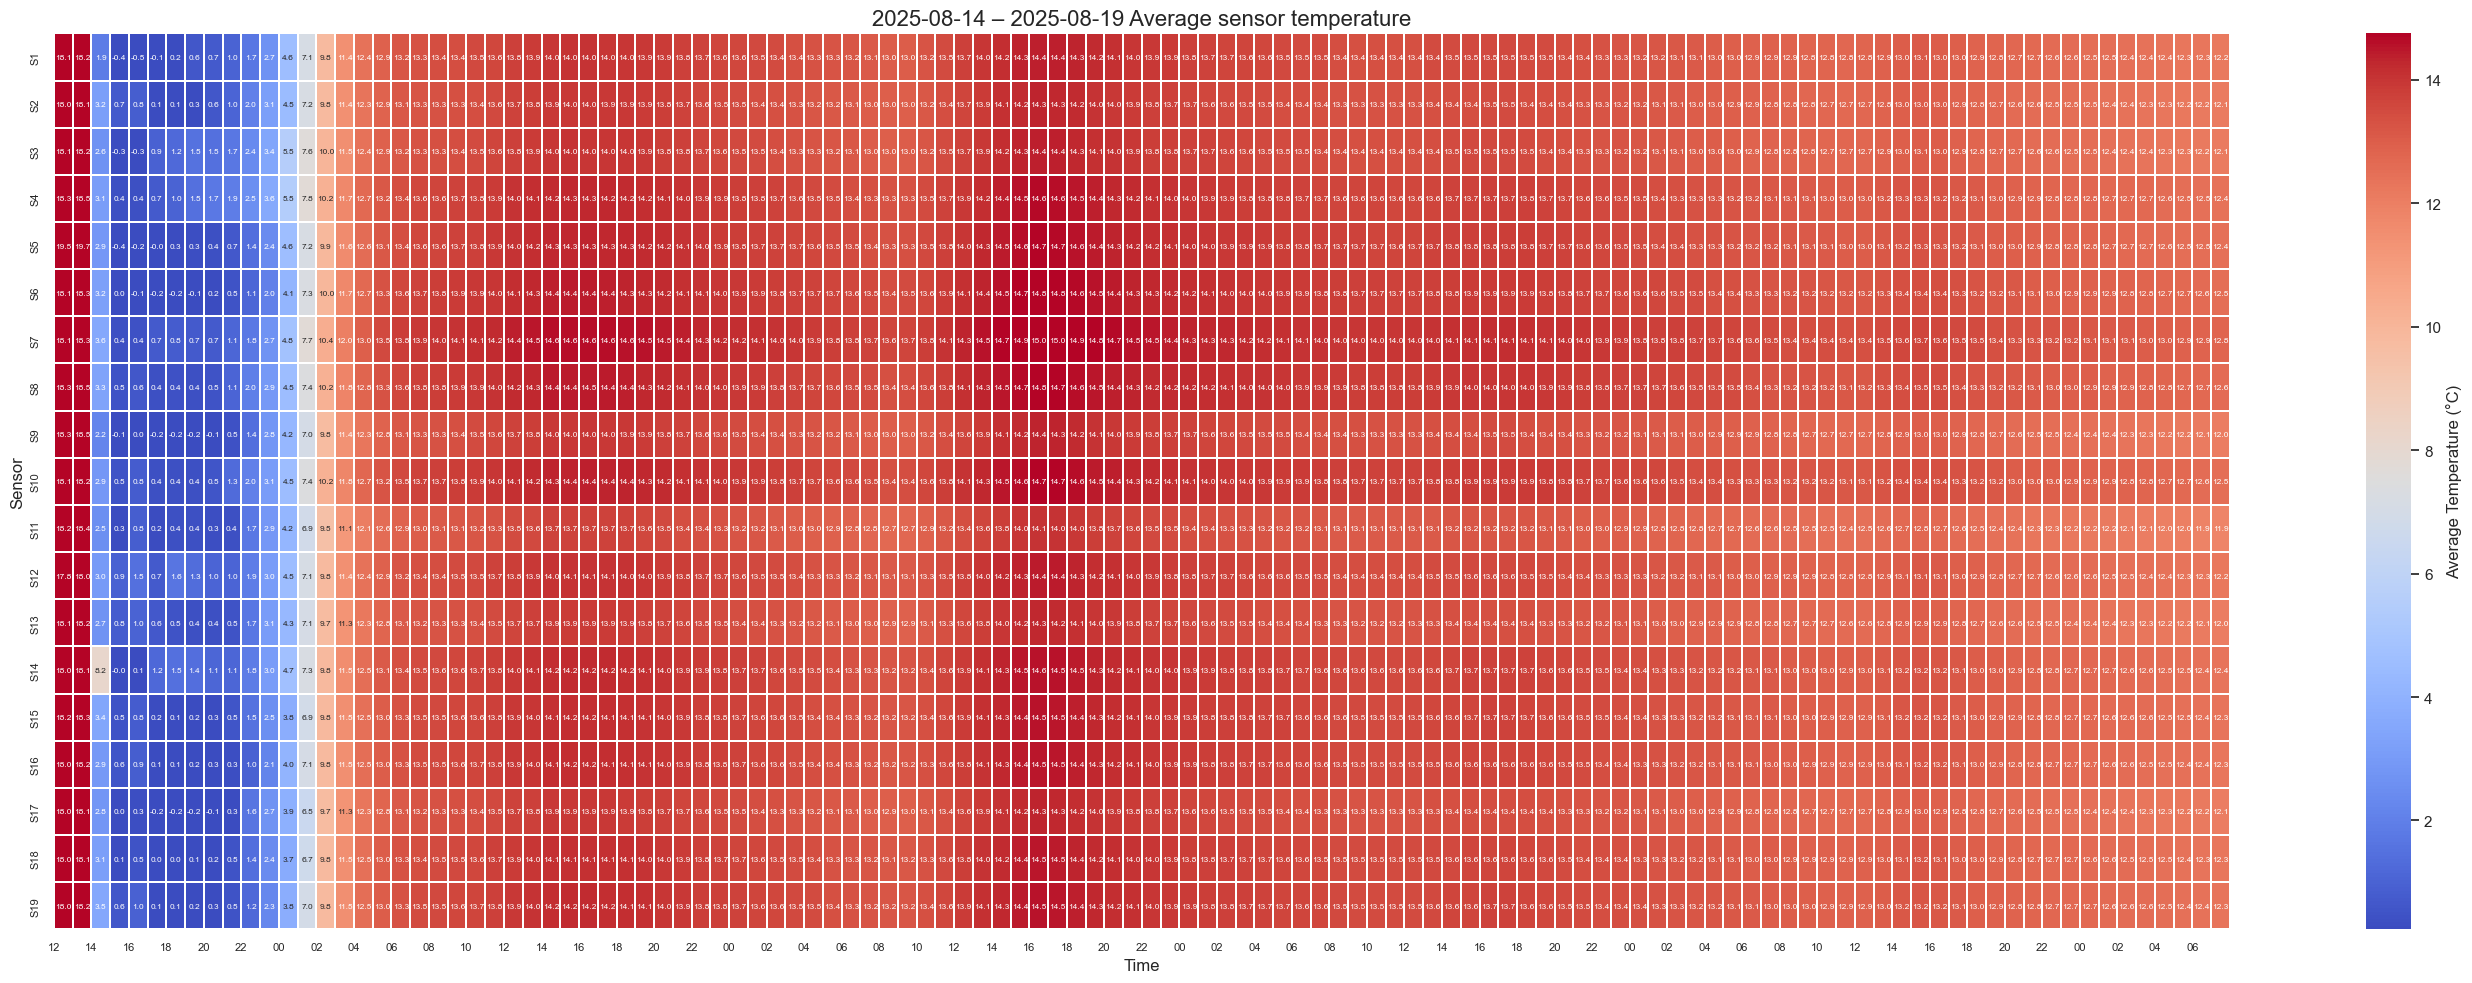

In [87]:
# Celda — Heatmap por día (promedio por hora y sensor con anotaciones simples)
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# ============== PARÁMETROS AJUSTABLES ==============
INPUT_CSV = 'Datalog_Filtered_log_R.csv'  # archivo de entrada

# 1) Menos columnas: subir intervalo temporal o subsamplear
RESAMPLE_RULE = '1H'      # '15Min', '30Min', '1H'
SUBSAMPLE_EVERY = None     # None o entero (p.ej., 4 = 1 de cada 4 columnas)

# 2) Anotaciones dentro de celdas (mostrar SOLO el promedio)
ANNOTATE = True            # True/False
CELL_TEXT_SIZE = 6         # tamaño de fuente de los números en celdas
LABEL_DECIMALS = 1         # decimales para °C cuando STANDARDIZE=False

# 3) Foco horario (filtra antes del resample)
BETWEEN_TIME = None        # None o ('10:00', '22:00')

# 4) Figura y ticks en X
FIGSIZE = (28, 10)
XTICK_EVERY_HOURS = 2      # ticks cada N horas
TICK_FONT_SIZE = 8

# 5) Small multiples: 1 heatmap por día además del global
PER_DAY_FIGS = True
PER_DAY_RESAMPLE = '30Min'
PER_DAY_FIGSIZE = (18, 8)
PER_DAY_ANNOTATE = False   # mejor sin anotaciones por día para claridad

# 6) Estandarizar por sensor (z-score) para ver anomalías
STANDARDIZE = False        # True → z-score (center=0) y etiquetas en z-score (usa LABEL_DECIMALS para formateo)

# 7) Clipping de rango de color (evitar que outliers “aplanen” todo)
CLIP_BY_QUANTILES = (0.02, 0.98)  # None o (q_low, q_high)
VMIN_FIXED = None          # Ej. 10  (anula quantiles si no es None)
VMAX_FIXED = None          # Ej. 40

# 8) Suavizado (media móvil) tras el resample
SMOOTH_WINDOW = None       # None o ventana tipo '45Min', '2H', etc.

# 9) Limitar sensores (ej. S1..S19)
MAX_SENSOR = 19            # None para no limitar, o un entero
# ===================================================


# ============== CARGA Y PREPARACIÓN ==============
df = pd.read_csv(INPUT_CSV)
df['Timestamp'] = pd.to_datetime(df['Date'] + ' ' + df['Time'])
df.set_index('Timestamp', inplace=True)

# Detectar columnas de sensores y ordenarlas
sensor_columns = sorted([c for c in df.columns if c.startswith('S')], key=lambda x: int(x[1:]))
if MAX_SENSOR is not None:
    sensor_columns = [c for c in sensor_columns if int(c[1:]) <= MAX_SENSOR]

# Coerción a numérico
for c in sensor_columns:
    df[c] = pd.to_numeric(df[c], errors='coerce')

# Foco horario
if BETWEEN_TIME is not None:
    start_t, end_t = BETWEEN_TIME
    df = df.between_time(start_t, end_t)

# ============== RESAMPLE Y (OPCIONAL) SUAVIZADO ==============
# PROMEDIO por hora (o regla indicada) → esto asegura que la celda representa SOLO el promedio hora×sensor
resampled_df = df[sensor_columns].resample(RESAMPLE_RULE).mean()

if SMOOTH_WINDOW:
    resampled_df = resampled_df.rolling(SMOOTH_WINDOW, min_periods=1).mean()

# Matriz para heatmap (filas = sensores, columnas = tiempo)
heatmap_data = resampled_df.transpose()

# (Opcional) Subsamplear columnas si todavía hay muchas
if SUBSAMPLE_EVERY and SUBSAMPLE_EVERY > 1:
    heatmap_data = heatmap_data.iloc[:, ::SUBSAMPLE_EVERY]

# ============== ESTANDARIZACIÓN / CLIPPING ==============
if STANDARDIZE:
    # z-score por sensor (fila)
    mu = heatmap_data.mean(axis=1)
    sigma = heatmap_data.std(axis=1).replace(0, np.nan)
    heatmap_plot = (heatmap_data - mu.values[:, None]) / sigma.values[:, None]
    cbar_label = 'z-score'
    vmin = vmax = None
    center = 0
    fmt_str = f'.{LABEL_DECIMALS}f'
else:
    heatmap_plot = heatmap_data
    cbar_label = 'Average Temperature (°C)'
    fmt_str = f'.{LABEL_DECIMALS}f'
    # Clipping por quantiles
    vmin = vmax = None
    if CLIP_BY_QUANTILES:
        flat = heatmap_plot.to_numpy().ravel()
        flat = flat[~np.isnan(flat)]
        if flat.size > 0:
            vmin = np.quantile(flat, CLIP_BY_QUANTILES[0])
            vmax = np.quantile(flat, CLIP_BY_QUANTILES[1])
    # Rango fijo opcional
    if VMIN_FIXED is not None:
        vmin = VMIN_FIXED
    if VMAX_FIXED is not None:
        vmax = VMAX_FIXED
    center = None

# ============== PLOTEO GLOBAL ==============
sns.set(context='notebook')
plt.figure(figsize=FIGSIZE)

ax = sns.heatmap(
    heatmap_plot,
    cmap='coolwarm',
    linewidths=.3,
    cbar_kws={'label': cbar_label},
    annot=ANNOTATE,               # ← números en celdas (solo el promedio)
    fmt=fmt_str,                  # ← formateo de las anotaciones (p.ej., .1f)
    annot_kws={'size': CELL_TEXT_SIZE},
    vmin=vmin,
    vmax=vmax,
    center=center
)

# Ticks en X cada N horas
cols = heatmap_plot.columns  # DatetimeIndex
if len(cols) > 0 and isinstance(cols, pd.DatetimeIndex):
    hourly_positions = [i for i, ts in enumerate(cols) if (ts.minute == 0 and (ts.hour % max(1, XTICK_EVERY_HOURS) == 0))]
    hourly_labels = [cols[i].strftime('%H') for i in hourly_positions]
    ax.set_xticks(hourly_positions)
    ax.set_xticklabels(hourly_labels, rotation=0, ha='center')

# Etiquetas y títulos
ax.tick_params(axis='x', labelsize=TICK_FONT_SIZE)
ax.tick_params(axis='y', labelsize=TICK_FONT_SIZE)

# Título con rango de fechas
if len(cols) > 0:
    days = cols.normalize()
    dmin, dmax = days.min(), days.max()
    title_date = dmin.strftime('%Y-%m-%d') if dmin == dmax else f'{dmin.strftime("%Y-%m-%d")} – {dmax.strftime("%Y-%m-%d")}'
else:
    title_date = ''

ax.set_title(f'{title_date} Average sensor temperature' + (' (z-score)' if STANDARDIZE else ''), fontsize=16)
ax.set_xlabel('Time', fontsize=12)
ax.set_ylabel('Sensor', fontsize=12)

plt.tight_layout()
plt.savefig('Heatmap.png', dpi=300, bbox_inches='tight')
plt.show()

# ============== SMALL MULTIPLES (UNO POR DÍA) ==============
if PER_DAY_FIGS:
    for day, g in df.groupby(df.index.date):
        per_day = g[sensor_columns].resample(PER_DAY_RESAMPLE).mean()
        if SMOOTH_WINDOW:
            per_day = per_day.rolling(SMOOTH_WINDOW, min_periods=1).mean()
        hm = per_day.transpose()

        # Estandarización opcional por día
        if STANDARDIZE:
            mu_d = hm.mean(axis=1)
            sigma_d = hm.std(axis=1).replace(0, np.nan)
            hm_plot = (hm - mu_d.values[:, None]) / sigma_d.values[:, None]
            vmin_d = vmax_d = None
            center_d = 0
            cbar_label_d = 'z-score'
            fmt_day = f'.{LABEL_DECIMALS}f'
        else:
            hm_plot = hm
            # Clipping similar al global
            vmin_d = vmax_d = None
            if CLIP_BY_QUANTILES:
                flat_d = hm_plot.to_numpy().ravel()
                flat_d = flat_d[~np.isnan(flat_d)]
                if flat_d.size > 0:
                    vmin_d = np.quantile(flat_d, CLIP_BY_QUANTILES[0])
                    vmax_d = np.quantile(flat_d, CLIP_BY_QUANTILES[1])
            if VMIN_FIXED is not None:
                vmin_d = VMIN_FIXED
            if VMAX_FIXED is not None:
                vmax_d = VMAX_FIXED
            center_d = None
            cbar_label_d = 'Average Temperature (°C)'
            fmt_day = f'.{LABEL_DECIMALS}f'

        plt.figure(figsize=PER_DAY_FIGSIZE)
        ax2 = sns.heatmap(
            hm_plot,
            cmap='coolwarm',
            linewidths=.3,
            cbar_kws={'label': cbar_label_d},
            annot=PER_DAY_ANNOTATE,     # por día, default False para no saturar
            fmt=fmt_day,
            annot_kws={'size': CELL_TEXT_SIZE},
            vmin=vmin_d,
            vmax=vmax_d,
            center=center_d
        )

        # Ticks cada N horas
        cols_d = hm_plot.columns
        if len(cols_d) > 0 and isinstance(cols_d, pd.DatetimeIndex):
            pos = [i for i, ts in enumerate(cols_d) if (ts.minute == 0 and (ts.hour % max(1, XTICK_EVERY_HOURS) == 0))]
            lab = [cols_d[i].strftime('%H') for i in pos]
            ax2.set_xticks(pos)
            ax2.set_xticklabels(lab, rotation=0, ha='center')

        ax2.tick_params(axis='x', labelsize=TICK_FONT_SIZE)
        ax2.tick_params(axis='y', labelsize=TICK_FONT_SIZE)
        ax2.set_title(f'{day} Average sensor temperature' + (' (z-score)' if STANDARDIZE else ''), fontsize=14)
        ax2.set_xlabel('Time', fontsize=11)
        ax2.set_ylabel('Sensor', fontsize=11)

        plt.tight_layout()
        outname = f'Heatmap_{day}.png'
        plt.savefig(outname, dpi=300, bbox_inches='tight')
        plt.close()


In [88]:
#Celda 6
# Selecciona todas las columnas cuyo nombre contiene 'S' (p.ej., S1, S2, ...).
# DataFrame.filter(like='S') filtra por subcadena en el nombre de columna.
# Select all columns whose name contains 'S' (e.g., S1, S2, ...).
# DataFrame.filter(like='S') filters by substring in the column name.
s_columns = df.filter(like='S')

# Calcula, para cada columna, (máximo - mínimo) usando agregaciones por columna.
# .max() y .min() en un DataFrame devuelven un Series con el máximo/mínimo de cada columna (axis=0 por defecto).
# Restar Series columna a columna produce el rango por sensor.
# For each column, compute (max - min) using per-column aggregations.
# .max() and .min() on a DataFrame return a Series with each column's max/min (axis=0 by default).
# Subtracting the Series column-wise yields the range per sensor.
s_range = s_columns.max() - s_columns.min()


In [89]:
#Celda maximos
# Rango de los datos por sensor: muestra la Series 's_range' (máximo - mínimo por cada columna S*).
# En un notebook, evaluar la variable la renderiza como tabla (índice = sensores, valor = rango).
# If you want it sorted: s_range.sort_values(ascending=False)
# If you prefer a DataFrame: s_range.rename('range').to_frame()
s_range


S1     19.01
S2     19.13
S3     18.82
S4     18.44
S5     20.62
S6     18.75
S7     18.76
S8     19.31
S9     19.94
S10    19.13
S11    19.12
S12    18.44
S13    18.76
S14    85.13
S15    18.38
S16    18.82
S17    19.19
S18    19.00
S19    18.88
dtype: float64

In [90]:
#Celda minimos 
# Mínimo por sensor: devuelve una Series con el valor mínimo de cada columna S*.
# DataFrame.min(axis=0, skipna=True) toma mínimos por columna e ignora NaN por defecto.
# Minimum per sensor: returns a Series with the minimum value for each S* column.
# DataFrame.min(axis=0, skipna=True) computes column-wise minima and skips NaN by default.
s_columns.min()

# Opcionales / Optional:
# s_columns.min().sort_values()            # ordenar de menor a mayor / sort ascending
# s_columns.min().rename('min').to_frame() # convertir a DataFrame con columna 'min' / to DataFrame


S1    -0.63
S2    -0.25
S3    -0.44
S4     0.25
S5    -0.81
S6    -0.25
S7    -0.13
S8     0.25
S9    -0.63
S10    0.00
S11   -0.31
S12   -0.06
S13   -0.13
S14   -0.13
S15    0.00
S16   -0.13
S17   -0.31
S18   -0.19
S19   -0.13
dtype: float64

In [91]:
# Calcular promedio de los mínimos por columna
promedio_minimos = s_columns.min().mean()
print("El promedio de las temperaturas minimas es:",promedio_minimos)


El promedio de las temperaturas minimas es: -0.21210526315789474


[Tiempo] Usando combinación 'Date'+'Time' (dayfirst=False).
Sensores detectados (19): S1, S2, S3, S4, S5, S6, S7, S8, S9, S10, S11, S12, S13, S14, S15, S16, S17, S18, S19
Δt (mediana) inferido: 60.000 s
Ventana suavizado: 1 muestras | Duración mínima plateau: 3 muestras
Ventana 'pre' para <0°C: 1 muestras | k (global): 6

=== Resultado GLOBAL (plateau ~ fusión) ===
{
  "global_start_ts": "2025-08-14 14:39:36",
  "global_end_ts": "2025-08-14 14:41:36",
  "global_duration_min": 2.0,
  "k_required": 6,
  "n_sensors": 19
}

=== Primer plateau por sensor ===
                  start_ts              end_ts  duration_min  mean_T_C  \
sensor                                                                   
S1                     NaT                 NaT           NaN       NaN   
S10                    NaT                 NaT           NaN       NaN   
S11    2025-08-14 15:06:36 2025-08-14 15:08:36          2.00 -0.170000   
S12    2025-08-14 14:24:36 2025-08-14 14:27:36          3.00 -0.045000

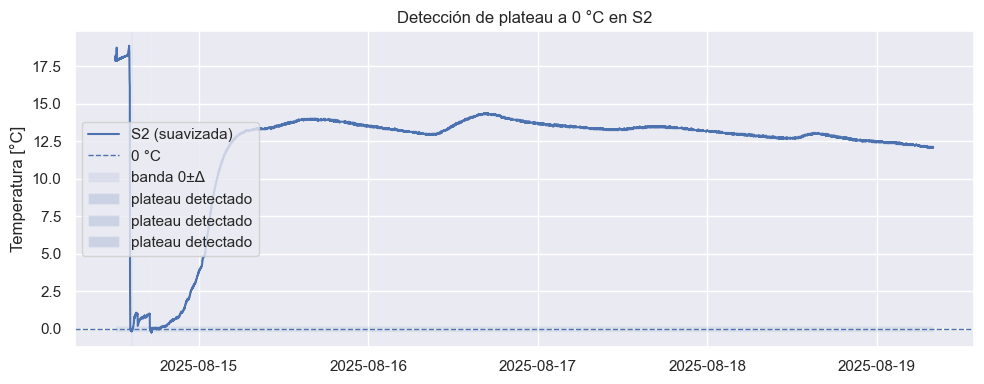

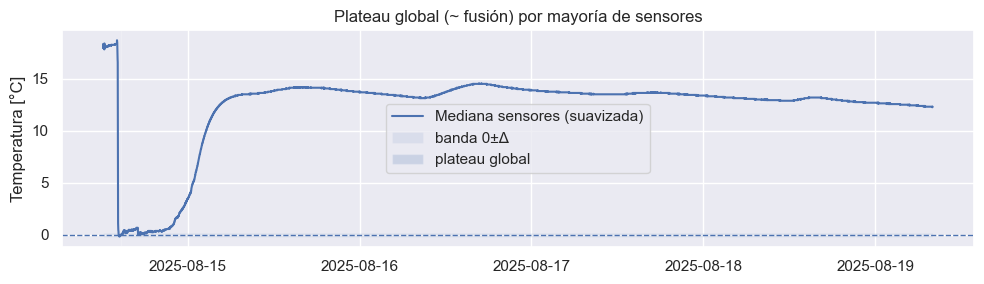

In [92]:
# === Detección de momentos de "hielo fundido" (~plateau a 0 °C) ===
# - Carga CSV, autodetecta tiempo (incluye combinación Date + Time/Hora si existen).
# - Detecta plateau por sensor y uno global (mayoría simultánea).
# - Robusto ante índice de tiempo NO único (evita el error de 'slice - slice').

import os
import re
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from math import ceil

# ---------------------- Parámetros ajustables ----------------------
CSV_PATH = "Datalog_Filtered_log_R.csv"  # usa ruta absoluta si no estás parado en esa carpeta
ZERO_BAND_C = 0.20           # Banda alrededor de 0°C para considerar "casi 0" (±0.20 °C)
SLOPE_THR_C_PER_MIN = 0.05   # Umbral de |pendiente| en °C/min para considerar "plateau"
MIN_DURATION_MIN = 3.0       # Duración mínima continua del plateau (minutos)
SMOOTHING_MIN = 0.5          # Ventana de suavizado (minutos) para temperatura y pendiente
REQUIRE_PRE_BELOW = True     # Exigir que antes del plateau se haya estado < 0°C
PRE_LOOKBACK_MIN = 1.0       # Ventana de mirada hacia atrás para verificar "<0°C" (minutos)
GLOBAL_K_FRACTION = 0.30     # Fracción de sensores simultáneos para declarar plateau global
# ------------------------------------------------------------------

def read_csv_safely(path):
    """Lee un CSV manejando decimal punto/coma."""
    try:
        return pd.read_csv(path)
    except Exception:
        return pd.read_csv(path, decimal=",")

def _build_out(df, dt, col):
    """Crea un DataFrame con índice datetime, filtrando filas no parseadas."""
    mask = dt.notna()
    if mask.mean() <= 0.7:
        return None
    out = df.loc[mask].copy()
    out.index = dt.loc[mask]
    if col in out.columns:
        out.drop(columns=[col], inplace=True)
    return out.sort_index()

def coerce_datetime_column(df):
    """
    Devuelve df con DateTimeIndex. Intenta:
    1) Combinación (Date/Fecha) + (Time/Hora)
    2) Una sola columna temporal (string)
    3) Epoch en s o ms.
    Prueba dayfirst False y True.
    """
    cols = list(df.columns)
    # Candidatas por nombre
    date_like = [c for c in cols if re.search(r"date|fecha", c, re.IGNORECASE)]
    time_like = [c for c in cols if re.search(r"time|hora", c, re.IGNORECASE)]

    # 1) Combinar Date+Time si están
    for dcol in date_like:
        for tcol in time_like:
            if dcol in df.columns and tcol in df.columns:
                s = (df[dcol].astype(str).str.strip() + " " +
                     df[tcol].astype(str).str.strip())
                for dayfirst in (False, True):
                    dt = pd.to_datetime(s, errors="coerce", dayfirst=dayfirst, utc=False)
                    out = _build_out(df, dt, col=None)  # no elimino columnas; mantén originales
                    if out is not None:
                        print(f"[Tiempo] Usando combinación '{dcol}'+'{tcol}' (dayfirst={dayfirst}).")
                        return out

    # 2) Una sola columna probable
    candidates = [c for c in cols if c.lower() in
                  ["timestamp","time","fecha","datetime","date","datetime_utc","created_at"]]
    try_list = []
    try_list.extend(candidates)
    if cols[0] not in try_list:
        try_list.append(cols[0])
    for c in cols:
        if re.search(r"time|fecha|date", c, re.IGNORECASE) and c not in try_list:
            try_list.append(c)

    for col in try_list:
        if col not in df.columns:
            continue
        # string datetime
        for dayfirst in (False, True):
            dt = pd.to_datetime(df[col], errors="coerce", dayfirst=dayfirst, utc=False)
            out = _build_out(df, dt, col)
            if out is not None:
                print(f"[Tiempo] Usando columna '{col}' (dayfirst={dayfirst}).")
                return out
        # epoch s y ms
        try:
            vals = pd.to_numeric(df[col], errors="coerce")
            dt = pd.to_datetime(vals, unit="s", errors="coerce", utc=False)
            out = _build_out(df, dt, col)
            if out is not None:
                print(f"[Tiempo] Usando columna '{col}' (epoch s).")
                return out
            dt = pd.to_datetime(vals, unit="ms", errors="coerce", utc=False)
            out = _build_out(df, dt, col)
            if out is not None:
                print(f"[Tiempo] Usando columna '{col}' (epoch ms).")
                return out
        except Exception:
            pass

    raise ValueError("No se pudo identificar una columna temporal válida (Date/Time).")

def detect_sensor_columns(df):
    """Columnas 'S1', 'S2', ... -> float."""
    sensors = [c for c in df.columns if re.match(r"^S\d+$", str(c), flags=re.IGNORECASE)]
    if not sensors:
        sensors = [c for c in df.columns if re.match(r"^S\d+", str(c), flags=re.IGNORECASE)]
    if not sensors:
        raise ValueError("No se encontraron columnas de sensores tipo 'S1', 'S2', ... en el CSV.")
    for s in sensors:
        if df[s].dtype == object:
            df[s] = df[s].astype(str).str.replace(",", ".", regex=False)
        df[s] = pd.to_numeric(df[s], errors="coerce")
    return sensors

def infer_dt_seconds(index):
    if not isinstance(index, pd.DatetimeIndex) or len(index) < 2:
        raise ValueError("Índice temporal inválido o con muy pocas filas.")
    diffs = np.diff(index.view("i8")) / 1e9  # ns -> s
    diffs = diffs[np.isfinite(diffs) & (diffs > 0)]
    if len(diffs) == 0:
        raise ValueError("No se pudo inferir Δt positivo del índice temporal (¿timestampts repetidos?).")
    return float(np.median(diffs))

def mins_to_samples(minutes, dt_sec):
    return max(1, int(round((minutes * 60.0) / dt_sec)))

def true_segments(ser_bool):
    """Devuelve lista de (start_label, end_label) para runs True."""
    if ser_bool.empty:
        return []
    shifted = ser_bool.astype(int).diff().fillna(int(ser_bool.iloc[0]))
    starts = ser_bool.index[(shifted == 1)]
    ends = ser_bool.index[(shifted == -1)]
    if ser_bool.iloc[0]:
        starts = starts.insert(0, ser_bool.index[0])
    if ser_bool.iloc[-1]:
        ends = ends.append(pd.Index([ser_bool.index[-1]]))
    return list(zip(starts, ends))

# --- helpers para índices NO únicos (evitan 'slice - slice') ---
def _pos_first(idx, label):
    loc = idx.get_loc(label)
    if isinstance(loc, slice):
        return loc.start
    if isinstance(loc, (np.ndarray, list)):
        return int(loc[0])
    return int(loc)

def _pos_last(idx, label):
    loc = idx.get_loc(label)
    if isinstance(loc, slice):
        return loc.stop - 1
    if isinstance(loc, (np.ndarray, list)):
        return int(loc[-1])
    return int(loc)

def seg_len_in_samples(idx, a, b):
    return _pos_last(idx, b) - _pos_first(idx, a) + 1

def came_from_below_zero(series, start_ts, pre_lookback_len):
    loc0 = _pos_first(series.index, start_ts)
    i0 = max(0, loc0 - pre_lookback_len)
    if i0 >= loc0:
        return False
    prev_med = series.iloc[i0:loc0].median()
    return np.isfinite(prev_med) and (prev_med < 0.0)

# ========================== MAIN ==========================
if not os.path.exists(CSV_PATH):
    raise FileNotFoundError(f"No se encontró el archivo: {CSV_PATH}")

raw = read_csv_safely(CSV_PATH)
df = coerce_datetime_column(raw)

sensors = detect_sensor_columns(df)
n_sensors = len(sensors)
print(f"Sensores detectados ({n_sensors}): {', '.join(sensors)}")

df = df.sort_index()
df_s = df[sensors].copy()

dt_sec = infer_dt_seconds(df_s.index)
print(f"Δt (mediana) inferido: {dt_sec:.3f} s")
if dt_sec >= 3600:
    print("[Aviso] El Δt es grande (≥ 1 h). Si esperabas resolución de minutos/segundos, "
          "asegúrate de que el parseo de tiempo incluyó la columna de 'hora'.")

win_smooth = mins_to_samples(SMOOTHING_MIN, dt_sec)
min_len = mins_to_samples(MIN_DURATION_MIN, dt_sec)
pre_lookback_len = mins_to_samples(PRE_LOOKBACK_MIN, dt_sec)
k_majority = max(3, int(ceil(GLOBAL_K_FRACTION * n_sensors)))

print(f"Ventana suavizado: {win_smooth} muestras | Duración mínima plateau: {min_len} muestras")
print(f"Ventana 'pre' para <0°C: {pre_lookback_len} muestras | k (global): {k_majority}")

# Suavizado y derivadas
T_smooth = df_s.rolling(win_smooth, min_periods=1, center=True).mean()
dT_dt = T_smooth.diff() / (dt_sec / 60.0)  # °C/min
dT_dt_smooth = dT_dt.rolling(win_smooth, min_periods=1, center=True).median()

# Máscaras de plateau
near_zero = T_smooth.abs() <= ZERO_BAND_C
low_slope = dT_dt_smooth.abs() <= SLOPE_THR_C_PER_MIN
plateau_mask = near_zero & low_slope

# Detección por sensor
results_per_sensor = []
for s in sensors:
    segs = true_segments(plateau_mask[s])
    # filtrar por longitud mínima usando posiciones (robusto a índice no único)
    segs = [(a, b) for (a, b) in segs if seg_len_in_samples(T_smooth.index, a, b) >= min_len]
    if REQUIRE_PRE_BELOW:
        segs = [(a, b) for (a, b) in segs if came_from_below_zero(T_smooth[s], a, pre_lookback_len)]
    if segs:
        a, b = segs[0]
        # cortes seguros usando labels
        seg_slice = T_smooth.loc[a:b, s]
        slope_slice = dT_dt_smooth.loc[a:b, s]
        results_per_sensor.append({
            "sensor": s,
            "start_ts": a,
            "end_ts": b,
            "duration_min": (pd.Timestamp(b) - pd.Timestamp(a)).total_seconds()/60.0,
            "mean_T_C": float(seg_slice.mean()),
            "std_T_C": float(seg_slice.std(ddof=0)),
            "median_slope_C_per_min": float(slope_slice.median()),
            "n_samples": int(len(seg_slice)),
        })
    else:
        results_per_sensor.append({
            "sensor": s,
            "start_ts": None,
            "end_ts": None,
            "duration_min": None,
            "mean_T_C": None,
            "std_T_C": None,
            "median_slope_C_per_min": None,
            "n_samples": 0,
        })

results_df = pd.DataFrame(results_per_sensor).set_index("sensor").sort_index()

# Detección global (k sensores en plateau simultáneo)
plateau_count = plateau_mask.sum(axis=1)
global_plateau = plateau_count >= k_majority
def true_segments_bool_index(ser_bool):
    return true_segments(ser_bool)  # reutiliza

global_segs = true_segments_bool_index(global_plateau)
global_segs = [(a, b) for (a, b) in global_segs if seg_len_in_samples(T_smooth.index, a, b) >= min_len]

if REQUIRE_PRE_BELOW and global_segs:
    median_T = T_smooth.median(axis=1)
    global_segs = [(a, b) for (a, b) in global_segs if came_from_below_zero(median_T, a, pre_lookback_len)]

if global_segs:
    g_start, g_end = global_segs[0]
    global_result = {
        "global_start_ts": str(g_start),
        "global_end_ts": str(g_end),
        "global_duration_min": (pd.Timestamp(g_end) - pd.Timestamp(g_start)).total_seconds()/60.0,
        "k_required": int(k_majority),
        "n_sensors": int(n_sensors)
    }
else:
    global_result = {
        "global_start_ts": None,
        "global_end_ts": None,
        "global_duration_min": None,
        "k_required": int(k_majority),
        "n_sensors": int(n_sensors)
    }

print("\n=== Resultado GLOBAL (plateau ~ fusión) ===")
print(json.dumps(global_result, indent=2, ensure_ascii=False))
print("\n=== Primer plateau por sensor ===")
print(results_df)

# Gráficos de apoyo
try:
    candidates = results_df.dropna(subset=["start_ts"])
    s_rep = candidates.sort_values("start_ts").index[0] if not candidates.empty else sensors[0]

    fig, ax = plt.subplots(figsize=(10, 4))
    ax.plot(T_smooth.index, T_smooth[s_rep], label=f"{s_rep} (suavizada)")
    ax.axhline(0, linestyle="--", linewidth=1, label="0 °C")
    ax.fill_between(T_smooth.index, -ZERO_BAND_C, ZERO_BAND_C, alpha=0.1, label="banda 0±Δ")

    segs_rep = true_segments(plateau_mask[s_rep])
    segs_rep = [(a, b) for (a, b) in segs_rep if seg_len_in_samples(T_smooth.index, a, b) >= min_len]
    if REQUIRE_PRE_BELOW:
        segs_rep = [(a, b) for (a, b) in segs_rep if came_from_below_zero(T_smooth[s_rep], a, pre_lookback_len)]
    for a, b in segs_rep:
        ax.axvspan(a, b, alpha=0.2, label="plateau detectado")

    ax.set_title(f"Detección de plateau a 0 °C en {s_rep}")
    ax.set_ylabel("Temperatura [°C]")
    ax.legend(loc="best")
    plt.tight_layout()
    plt.show()

    fig, ax = plt.subplots(figsize=(10, 3))
    med = T_smooth.median(axis=1)
    ax.plot(med.index, med, label="Mediana sensores (suavizada)")
    ax.axhline(0, linestyle="--", linewidth=1)
    ax.fill_between(med.index, -ZERO_BAND_C, ZERO_BAND_C, alpha=0.1, label="banda 0±Δ")
    for a, b in global_segs:
        ax.axvspan(a, b, alpha=0.2, label="plateau global")
    ax.set_title("Plateau global (~ fusión) por mayoría de sensores")
    ax.set_ylabel("Temperatura [°C]")
    ax.legend(loc="best")
    plt.tight_layout()
    plt.show()
except Exception as e:
    print("No se pudieron generar los gráficos:", repr(e))


In [93]:
# --- Chequeo rápido del entorno: existen y son razonables? ---
import pandas as pd
import numpy as np

def _ok_df(df):
    return isinstance(df, pd.DataFrame) and (df.shape[0] > 0) and (df.shape[1] > 0)

def _exists(name):
    return (name in globals()) and (globals()[name] is not None)

def check_autocontenida():
    missing = []
    report = {}

    # T_smooth
    if _exists("T_smooth") and _ok_df(globals()["T_smooth"]):
        df = globals()["T_smooth"]
        report["T_smooth"] = f"OK: DataFrame {df.shape}, índice={type(df.index).__name__}"
    else:
        missing.append("T_smooth")

    # dt_sec
    if _exists("dt_sec") and isinstance(globals()["dt_sec"], (int, float)) and globals()["dt_sec"] > 0:
        report["dt_sec"] = f"OK: {globals()['dt_sec']:.3f} s"
    else:
        missing.append("dt_sec")

    # sensors
    if _exists("sensors") and isinstance(globals()["sensors"], (list, tuple)) and len(globals()["sensors"]) > 0:
        # chequeo cruzado con T_smooth (si existe)
        if "T_smooth" in globals():
            cols = set(globals()["T_smooth"].columns)
            bad = [s for s in globals()["sensors"] if s not in cols]
            if bad:
                report["sensors"] = f"ADVERTENCIA: {len(bad)} sensores no están en T_smooth: {bad[:5]}"
            else:
                report["sensors"] = f"OK: {len(globals()['sensors'])} sensores"
        else:
            report["sensors"] = f"OK: {len(globals()['sensors'])} sensores"
    else:
        missing.append("sensors")

    # ZERO_BAND_C
    if _exists("ZERO_BAND_C") and isinstance(globals()["ZERO_BAND_C"], (int, float)) and globals()["ZERO_BAND_C"] > 0:
        report["ZERO_BAND_C"] = f"OK: {globals()['ZERO_BAND_C']}"
    else:
        missing.append("ZERO_BAND_C")

    print("== Reporte ==")
    for k, v in report.items():
        print(f"{k}: {v}")

    if missing:
        print("\n❌ Faltan/incorrectas:", ", ".join(missing))
        return False
    else:
        print("\n✅ Todo listo: la celda siguiente puede usar estas variables.")
        return True

_ = check_autocontenida()


== Reporte ==
T_smooth: OK: DataFrame (6950, 19), índice=DatetimeIndex
dt_sec: OK: 60.000 s
sensors: OK: 19 sensores
ZERO_BAND_C: OK: 0.2

✅ Todo listo: la celda siguiente puede usar estas variables.


=== Resumen por sensor ===
             plateau_start         plateau_end  plateau_duration_min  \
sensor                                                                 
S1                     NaT                 NaT                   NaN   
S10                    NaT                 NaT                   NaN   
S11    2025-08-14 15:06:36 2025-08-14 15:08:36                  2.00   
S12    2025-08-14 14:24:36 2025-08-14 14:27:36                  3.00   
S13    2025-08-14 14:35:36 2025-08-14 14:37:36                  2.00   
S14                    NaT                 NaT                   NaN   
S15                    NaT                 NaT                   NaN   
S16    2025-08-14 14:26:36 2025-08-14 14:33:36                  7.00   
S17    2025-08-14 15:08:36 2025-08-14 15:12:21                  3.75   
S18    2025-08-14 14:32:36 2025-08-14 14:35:36                  3.00   
S19    2025-08-14 14:25:36 2025-08-14 14:28:36                  3.00   
S2     2025-08-14 14:21:36 2025-08-14

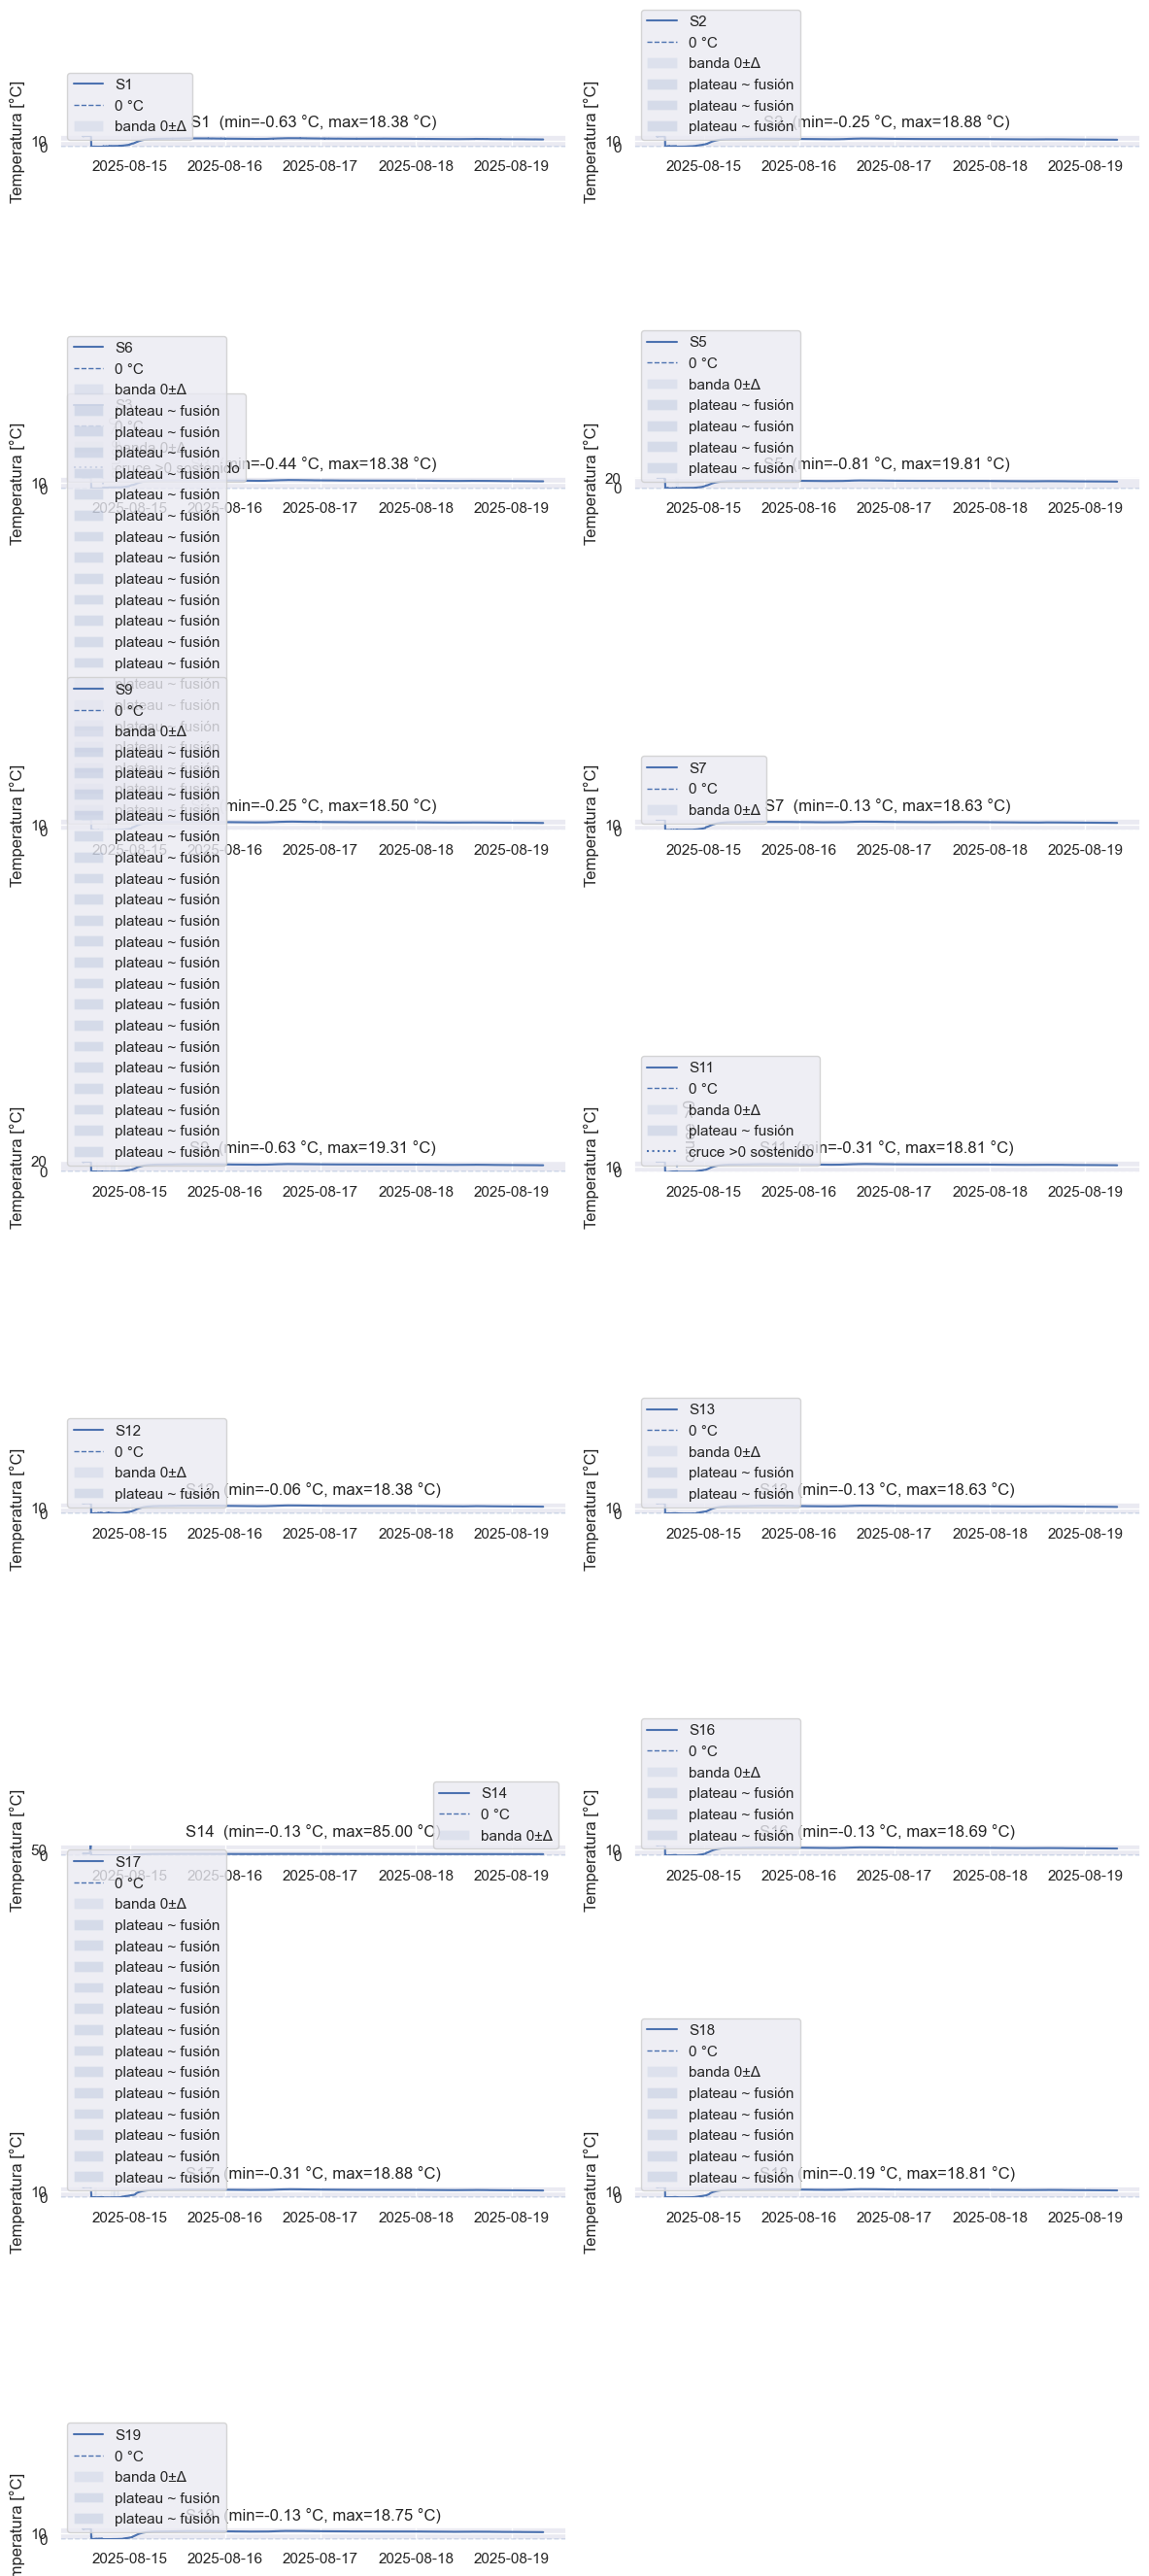

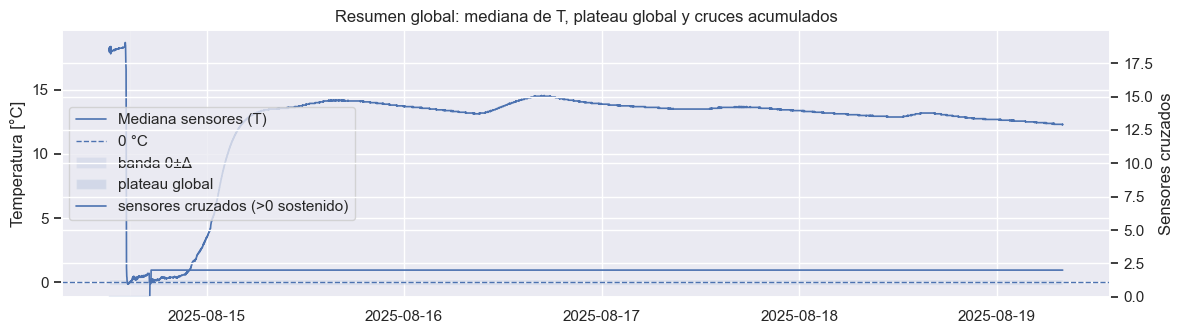


Archivo de resumen guardado en: fusion_detection_summary.csv


In [94]:
# === Detección integrada de "hielo fundido": plateau ~ 0 °C + cruce sostenido > 0 °C ===
# Requisitos: T_smooth (DataFrame, índice DateTime), dt_sec (float, s), sensors (lista), ZERO_BAND_C (float)
# Salidas:
#   - fusion_summary (DataFrame con tiempos por sensor)
#   - global_summary (dict con eventos globales)
#   - gráficos por sensor y global
#   - archivo 'fusion_detection_summary.csv'

import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ---------------- Parámetros (ajusta si es necesario) ----------------
# Criterio de plateau
SLOPE_THR_C_PER_MIN = 0.05   # |pendiente| <= 0.05 °C/min se considera "casi constante"
MIN_PLATEAU_MIN     = 3.0    # duración mínima del plateau en minutos
REQUIRE_PRE_BELOW   = True   # exigir venir desde < 0 °C antes del plateau (robusto)
# Criterio de cruce sostenido
EPS_NEG  = 0.05              # exige haber estado < -0.05 °C en algún momento
EPS_POS  = 0.15              # exige superar +0.15 °C (histéresis anti-ruido)
HOLD_MIN = 3.0               # mantener > +EPS_POS durante al menos 3 min
# Mayoría global (p. ej. 30% de sensores)
GLOBAL_K_FRACTION = 0.30

# ---------------- Derivadas y máscaras (a partir de T_smooth) ----------------
win_slope = max(1, int(round((0.5*60.0)/dt_sec)))  # suavizado de derivada (0.5 min)
dT_dt = T_smooth.diff() / (dt_sec / 60.0)  # °C/min
dT_dt_smooth = dT_dt.rolling(win_slope, min_periods=1, center=True).median()

near_zero = T_smooth.abs() <= ZERO_BAND_C
low_slope = dT_dt_smooth.abs() <= SLOPE_THR_C_PER_MIN
plateau_mask = near_zero & low_slope

min_len = max(1, int(round((MIN_PLATEAU_MIN*60.0)/dt_sec)))
hold_len = max(1, int(round((HOLD_MIN*60.0)/dt_sec)))
k_majority = max(3, int(math.ceil(GLOBAL_K_FRACTION * len(sensors))))

# ---------------- Utilidades robustas (índices no únicos) ----------------
def true_segments(ser_bool):
    """Runs True -> lista de (start_label, end_label)."""
    if ser_bool.empty:
        return []
    shifted = ser_bool.astype(int).diff().fillna(int(ser_bool.iloc[0]))
    starts = ser_bool.index[(shifted == 1)]
    ends   = ser_bool.index[(shifted == -1)]
    if ser_bool.iloc[0]:
        starts = starts.insert(0, ser_bool.index[0])
    if ser_bool.iloc[-1]:
        ends = ends.append(pd.Index([ser_bool.index[-1]]))
    return list(zip(starts, ends))

def _pos_first(idx, label):
    loc = idx.get_loc(label)
    if isinstance(loc, slice): return loc.start
    if isinstance(loc, (np.ndarray, list)): return int(loc[0])
    return int(loc)

def _pos_last(idx, label):
    loc = idx.get_loc(label)
    if isinstance(loc, slice): return loc.stop - 1
    if isinstance(loc, (np.ndarray, list)): return int(loc[-1])
    return int(loc)

def seg_len_in_samples(idx, a, b):
    return _pos_last(idx, b) - _pos_first(idx, a) + 1

def came_from_below_zero(series, start_ts, lookback_len):
    loc0 = _pos_first(series.index, start_ts)
    i0 = max(0, loc0 - lookback_len)
    if i0 >= loc0:
        return False
    prev_med = series.iloc[i0:loc0].median()
    return np.isfinite(prev_med) and (prev_med < 0.0)

def first_sustained_crossing(x, pos_eps=EPS_POS, hold=hold_len, require_prior_below=True, neg_eps=EPS_NEG):
    """
    Primer instante en que x pasa de <=0 a >pos_eps y se mantiene >pos_eps por 'hold' muestras.
    (Opcional) exige que haya valores < -neg_eps antes del cruce.
    """
    x = x.dropna()
    if x.empty:
        return None
    if require_prior_below and not (x < -neg_eps).any():
        return None
    for i in range(1, len(x)-hold):
        if (x.iloc[i-1] <= 0) and (x.iloc[i] > pos_eps) and (x.iloc[i:i+hold].gt(pos_eps).all()):
            if not require_prior_below or (x.iloc[:i].lt(-neg_eps).any()):
                return x.index[i]
    return None

# ---------------- Detección por sensor ----------------
rows = []
pre_lookback_len = max(1, int(round((1.0*60.0)/dt_sec)))  # mirar 1 min hacia atrás

for s in sensors:
    # Plateaus para el sensor
    segs = true_segments(plateau_mask[s])
    segs = [(a, b) for (a, b) in segs if seg_len_in_samples(T_smooth.index, a, b) >= min_len]
    if REQUIRE_PRE_BELOW:
        segs = [(a, b) for (a, b) in segs if came_from_below_zero(T_smooth[s], a, pre_lookback_len)]

    if segs:
        a, b = segs[0]
        seg_slice = T_smooth.loc[a:b, s]
        slope_slice = dT_dt_smooth.loc[a:b, s]
        start_plateau, end_plateau = a, b
        dur_plateau_min = (pd.Timestamp(b) - pd.Timestamp(a)).total_seconds()/60.0
        mean_T = float(seg_slice.mean())
        std_T  = float(seg_slice.std(ddof=0))
        med_slope = float(slope_slice.median())
    else:
        start_plateau = end_plateau = None
        dur_plateau_min = mean_T = std_T = med_slope = None

    # Cruce sostenido > 0 °C
    cross_ts = first_sustained_crossing(T_smooth[s])

    rows.append({
        "sensor": s,
        "plateau_start": start_plateau,
        "plateau_end": end_plateau,
        "plateau_duration_min": dur_plateau_min,
        "plateau_mean_T_C": mean_T,
        "plateau_std_T_C": std_T,
        "plateau_median_slope_C_per_min": med_slope,
        "sustained_cross_ts": cross_ts
    })

fusion_summary = pd.DataFrame(rows).set_index("sensor").sort_index()
print("=== Resumen por sensor ===")
print(fusion_summary)

# ---------------- Detección GLOBAL (mayoría simultánea) ----------------
plateau_count = plateau_mask.sum(axis=1)
global_plateau = plateau_count >= k_majority
gsegs = true_segments(global_plateau)
gsegs = [(a, b) for (a, b) in gsegs if seg_len_in_samples(T_smooth.index, a, b) >= min_len]

if REQUIRE_PRE_BELOW and gsegs:
    median_T = T_smooth.median(axis=1)
    gsegs = [(a, b) for (a, b) in gsegs if came_from_below_zero(median_T, a, pre_lookback_len)]

if gsegs:
    g_start, g_end = gsegs[0]
    g_duration_min = (pd.Timestamp(g_end) - pd.Timestamp(g_start)).total_seconds()/60.0
else:
    g_start = g_end = None
    g_duration_min = None

# Global: cruce sostenido por mayoría (cuando ≥k sensores ya cruzaron)
cross_series = pd.Series(
    {s: fusion_summary.loc[s, "sustained_cross_ts"] for s in sensors},
    name="cross_ts"
).dropna().sort_values()

if not cross_series.empty:
    # tiempo en el que se alcanza la k-ésima detección
    if len(cross_series) >= k_majority:
        g_cross_majority_ts = cross_series.iloc[k_majority-1]
    else:
        g_cross_majority_ts = None
else:
    g_cross_majority_ts = None

global_summary = {
    "k_required": int(k_majority),
    "n_sensors": int(len(sensors)),
    "global_plateau_start": str(g_start) if g_start is not None else None,
    "global_plateau_end": str(g_end) if g_end is not None else None,
    "global_plateau_duration_min": g_duration_min,
    "global_sustained_cross_majority_ts": str(g_cross_majority_ts) if g_cross_majority_ts is not None else None
}

print("\n=== Resumen GLOBAL ===")
print(global_summary)

# ---------------- Gráficos: sensores que bajaron de 0 y luego superaron 0 ----------------
def select_sensors_below_then_above(df_T, eps_neg=EPS_NEG, eps_pos=EPS_POS):
    sel = []
    for s in sensors:
        x = df_T[s].dropna()
        if x.empty:
            continue
        if (x < -eps_neg).any() and (x > +eps_pos).any():
            sel.append(s)
    return sel

selected = select_sensors_below_then_above(T_smooth)
print(f"\nSensores con (<-{EPS_NEG} °C) y luego (>+{EPS_POS} °C): {', '.join(selected) or '(ninguno)'}")

if selected:
    n = len(selected)
    ncols = 2
    nrows = math.ceil(n / ncols)
    fig, axes = plt.subplots(nrows, ncols, figsize=(12, 3.2*nrows), sharex=False)
    if nrows*ncols == 1:
        axes = [axes]
    else:
        axes = axes.ravel()

    for ax, s in zip(axes, selected):
        x = T_smooth[s]
        ax.plot(x.index, x, label=s)
        ax.axhline(0, linestyle="--", linewidth=1, label="0 °C")
        ax.fill_between(x.index, -ZERO_BAND_C, ZERO_BAND_C, alpha=0.1, label="banda 0±Δ")

        # Sombrear plateaus detectados
        segs = true_segments(plateau_mask[s])
        segs = [(a, b) for (a, b) in segs if seg_len_in_samples(T_smooth.index, a, b) >= min_len]
        if REQUIRE_PRE_BELOW:
            segs = [(a, b) for (a, b) in segs if came_from_below_zero(T_smooth[s], a, pre_lookback_len)]
        for a, b in segs:
            ax.axvspan(a, b, alpha=0.15, label="plateau ~ fusión")

        # Línea vertical en el cruce sostenido
        t = fusion_summary.loc[s, "sustained_cross_ts"]
        if pd.notna(t):
            ax.axvline(t, linestyle=":", linewidth=1.5, label="cruce >0 sostenido")
            ax.annotate("cruce >0", xy=(pd.Timestamp(t), 0), xytext=(5, 8),
                        textcoords="offset points", rotation=90, va="bottom")

        ax.set_title(f"{s}  (min={x.min():.2f} °C, max={x.max():.2f} °C)")
        ax.set_ylabel("Temperatura [°C]")
        ax.legend(loc="best")

    # Ocultar ejes sobrantes si los hay
    for j in range(len(selected), len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()

# ---------------- Gráfico global: mediana + plateau global + conteo de cruces ----------------
try:
    med = T_smooth.median(axis=1)
    fig, ax1 = plt.subplots(figsize=(12, 3.5))
    ax1.plot(med.index, med, label="Mediana sensores (T)", linewidth=1.2)
    ax1.axhline(0, linestyle="--", linewidth=1, label="0 °C")
    ax1.fill_between(med.index, -ZERO_BAND_C, ZERO_BAND_C, alpha=0.1, label="banda 0±Δ")

    # Sombrear plateau global si existe
    for a, b in gsegs:
        ax1.axvspan(a, b, alpha=0.15, label="plateau global")

    ax1.set_ylabel("Temperatura [°C]")
    ax1.set_title("Resumen global: mediana de T, plateau global y cruces acumulados")

    # Segundo eje: número de sensores que ya cruzaron >0 sostenido
    ax2 = ax1.twinx()
    # Serie escalonada de cruces
    crosses_sorted = cross_series if not cross_series.empty else pd.Series([], dtype="datetime64[ns]")
    if not crosses_sorted.empty:
        steps = pd.Series(range(1, len(crosses_sorted)+1), index=crosses_sorted)
        steps = steps.reindex(med.index.union(steps.index)).sort_index().ffill().reindex(med.index).fillna(0)
        ax2.plot(med.index, steps, linestyle="-", linewidth=1.2, label="sensores cruzados (>0 sostenido)")
        ax2.set_ylabel("Sensores cruzados")
        ax2.set_ylim(0, len(sensors)*1.05)
        # Marca de mayoría
        if g_cross_majority_ts is not None:
            ax2.axvline(pd.Timestamp(g_cross_majority_ts), linestyle=":", linewidth=1.2,
                        label=f"mayoría cruzada (k={k_majority})")

    # Leyendas combinadas
    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax1.legend(lines1+lines2, labels1+labels2, loc="best")

    plt.tight_layout()
    plt.show()
except Exception as e:
    print("No se pudo generar el gráfico global:", repr(e))

# ---------------- Guardar resumen a CSV ----------------
out_path = "fusion_detection_summary.csv"
fusion_summary.to_csv(out_path, index=True)
print(f"\nArchivo de resumen guardado en: {out_path}")


In [95]:
# === Exportar gráficas individuales por sensor + gráfica global (promedio) ===
# Requiere: T_smooth (DataFrame con DateTimeIndex), dt_sec (float, s), sensors (lista), ZERO_BAND_C (float)

import os, math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ---------------- Parámetros (ajustables) ----------------
# Criterio de plateau (cerca de 0 °C y pendiente pequeña, viniendo desde < 0 °C)
SLOPE_THR_C_PER_MIN = 0.05     # |pendiente| <= 0.05 °C/min
MIN_PLATEAU_MIN     = 3.0      # duración mínima del plateau en minutos
REQUIRE_PRE_BELOW   = True     # exigir venir desde < 0 °C antes del plateau

# Criterio de cruce sostenido > 0 °C (histéresis anti-ruido)
EPS_NEG  = 0.05                # alguna vez < -0.05 °C
EPS_POS  = 0.15                # cruce por encima de +0.15 °C
HOLD_MIN = 3.0                 # sostener > +EPS_POS por 3 min

# Cómo decidir si “cumple hielo fundido”:
#   False -> basta con (plateau) OR (cruce sostenido)
#   True  -> exige (plateau) AND (cruce sostenido) (más estricto)
STRICT_CRITERION = False

# Destino de archivos
OUT_DIR = "fusion_plots"
OUT_DIR_INDIV = os.path.join(OUT_DIR, "individual")
os.makedirs(OUT_DIR_INDIV, exist_ok=True)

# ---------------- Preparativos (derivadas, máscaras) ----------------
win_slope = max(1, int(round((0.5*60.0)/dt_sec)))  # suavizado de derivada (0.5 min)
dT_dt = T_smooth.diff() / (dt_sec / 60.0)          # °C/min
dT_dt_smooth = dT_dt.rolling(win_slope, min_periods=1, center=True).median()

near_zero = T_smooth.abs() <= ZERO_BAND_C
low_slope = dT_dt_smooth.abs() <= SLOPE_THR_C_PER_MIN
plateau_mask = near_zero & low_slope

min_len  = max(1, int(round((MIN_PLATEAU_MIN*60.0)/dt_sec)))
hold_len = max(1, int(round((HOLD_MIN*60.0)/dt_sec)))
pre_lookback_len = max(1, int(round((1.0*60.0)/dt_sec)))  # 1 min hacia atrás

# ---------------- Utilidades robustas (índices no únicos) ----------------
def true_segments(ser_bool):
    if ser_bool.empty: return []
    shifted = ser_bool.astype(int).diff().fillna(int(ser_bool.iloc[0]))
    starts = ser_bool.index[(shifted == 1)]
    ends   = ser_bool.index[(shifted == -1)]
    if ser_bool.iloc[0]:  starts = starts.insert(0, ser_bool.index[0])
    if ser_bool.iloc[-1]: ends = ends.append(pd.Index([ser_bool.index[-1]]))
    return list(zip(starts, ends))

def _pos_first(idx, label):
    loc = idx.get_loc(label)
    if isinstance(loc, slice): return loc.start
    if isinstance(loc, (np.ndarray, list)): return int(loc[0])
    return int(loc)

def _pos_last(idx, label):
    loc = idx.get_loc(label)
    if isinstance(loc, slice): return loc.stop-1
    if isinstance(loc, (np.ndarray, list)): return int(loc[-1])
    return int(loc)

def seg_len_in_samples(idx, a, b):
    return _pos_last(idx, b) - _pos_first(idx, a) + 1

def came_from_below_zero(series, start_ts, lookback_len):
    loc0 = _pos_first(series.index, start_ts)
    i0 = max(0, loc0 - lookback_len)
    if i0 >= loc0: return False
    prev_med = series.iloc[i0:loc0].median()
    return np.isfinite(prev_med) and (prev_med < 0.0)

def first_sustained_crossing(x, pos_eps=EPS_POS, hold=hold_len, require_prior_below=True, neg_eps=EPS_NEG):
    x = x.dropna()
    if x.empty: return None
    if require_prior_below and not (x < -neg_eps).any(): return None
    for i in range(1, len(x)-hold):
        if (x.iloc[i-1] <= 0) and (x.iloc[i] > pos_eps) and (x.iloc[i:i+hold].gt(pos_eps).all()):
            if not require_prior_below or (x.iloc[:i].lt(-neg_eps).any()):
                return x.index[i]
    return None

# ---------------- Decisión por sensor (plateau y/o cruce) ----------------
selected = []
per_sensor_info = {}

for s in sensors:
    # Plateaus
    segs = true_segments(plateau_mask[s])
    segs = [(a,b) for (a,b) in segs if seg_len_in_samples(T_smooth.index, a, b) >= min_len]
    if REQUIRE_PRE_BELOW:
        segs = [(a,b) for (a,b) in segs if came_from_below_zero(T_smooth[s], a, pre_lookback_len)]
    plateau_ok = len(segs) > 0
    plateau_first = segs[0] if plateau_ok else (None, None)

    # Cruce sostenido
    cr_ts = first_sustained_crossing(T_smooth[s])
    cross_ok = cr_ts is not None

    # Decisión de “cumple”
    melts = (plateau_ok and cross_ok) if STRICT_CRITERION else (plateau_ok or cross_ok)
    if melts:
        selected.append(s)
    per_sensor_info[s] = {
        "plateau_segments": segs,
        "plateau_first": plateau_first,
        "sustained_cross_ts": cr_ts,
        "melts": melts
    }

print(f"Sensores que cumplen criterio de 'hielo fundido' ({'estricto' if STRICT_CRITERION else 'flexible'}): "
      f"{', '.join(selected) or '(ninguno)'}")

# ---------------- Gráficas individuales y guardado ----------------
saved = []
for s in selected:
    x = T_smooth[s]
    fig, ax = plt.subplots(figsize=(10, 3.6))
    ax.plot(x.index, x, label=s)
    ax.axhline(0, linestyle="--", linewidth=1, label="0 °C")
    ax.fill_between(x.index, -ZERO_BAND_C, ZERO_BAND_C, alpha=0.1, label="banda 0±Δ")

    # Plateaus
    for a, b in per_sensor_info[s]["plateau_segments"]:
        ax.axvspan(a, b, alpha=0.15, label="plateau ~ fusión")

    # Cruce sostenido
    t = per_sensor_info[s]["sustained_cross_ts"]
    if pd.notna(t):
        ax.axvline(t, linestyle=":", linewidth=1.5, label="cruce >0 sostenido")
        ax.annotate("cruce >0", xy=(pd.Timestamp(t), 0), xytext=(5, 8),
                    textcoords="offset points", rotation=90, va="bottom")

    ax.set_title(f"{s}  (min={x.min():.2f} °C, max={x.max():.2f} °C)")
    ax.set_ylabel("Temperatura [°C]")
    ax.legend(loc="best")
    plt.tight_layout()

    out_file = os.path.join(OUT_DIR_INDIV, f"{s}.png")
    fig.savefig(out_file, dpi=180)
    plt.close(fig)
    saved.append(out_file)

print(f"\nGuardados {len(saved)} PNG individuales en: {OUT_DIR_INDIV}")

# ---------------- Gráfica GLOBAL basada en PROMEDIO ----------------
# Promedio sólo de los sensores seleccionados (si no hay, usa todos)
if selected:
    mean_series = T_smooth[selected].mean(axis=1)
else:
    mean_series = T_smooth.mean(axis=1)

# Plateau global sobre el promedio
near_zero_mean = mean_series.abs() <= ZERO_BAND_C
low_slope_mean = (mean_series.diff()/(dt_sec/60.0)).rolling(win_slope, min_periods=1, center=True).median().abs() <= SLOPE_THR_C_PER_MIN
plateau_mean_mask = near_zero_mean & low_slope_mean
def true_segments_1d(ser_bool):
    if ser_bool.empty: return []
    shifted = ser_bool.astype(int).diff().fillna(int(ser_bool.iloc[0]))
    starts = ser_bool.index[(shifted == 1)]
    ends   = ser_bool.index[(shifted == -1)]
    if ser_bool.iloc[0]:  starts = starts.insert(0, ser_bool.index[0])
    if ser_bool.iloc[-1]: ends = ends.append(pd.Index([ser_bool.index[-1]]))
    return list(zip(starts, ends))
gsegs_mean = true_segments_1d(plateau_mean_mask)
# filtrar por duración mínima
def _len_samples_1d(idx, a, b):
    return _pos_last(idx, b) - _pos_first(idx, a) + 1
gsegs_mean = [(a,b) for (a,b) in gsegs_mean if _len_samples_1d(mean_series.index, a, b) >= min_len]

fig, ax = plt.subplots(figsize=(12, 3.6))
ax.plot(mean_series.index, mean_series, label="Promedio sensores (seleccionados)")
ax.axhline(0, linestyle="--", linewidth=1, label="0 °C")
ax.fill_between(mean_series.index, -ZERO_BAND_C, ZERO_BAND_C, alpha=0.1, label="banda 0±Δ")
for a, b in gsegs_mean:
    ax.axvspan(a, b, alpha=0.15, label="plateau global (promedio)")
ax.set_ylabel("Temperatura [°C]")
ax.set_title("Representación global basada en PROMEDIO")
ax.legend(loc="best")
plt.tight_layout()
out_global = os.path.join(OUT_DIR, "global_promedio.png")
fig.savefig(out_global, dpi=180)
plt.close(fig)

print(f"Gráfica global guardada en: {out_global}")


Sensores que cumplen criterio de 'hielo fundido' (flexible): S2, S3, S5, S6, S9, S11, S12, S13, S16, S17, S18, S19

Guardados 12 PNG individuales en: fusion_plots/individual
Gráfica global guardada en: fusion_plots/global_promedio.png


In [96]:
# === Gráficas individuales (sin banda ni sombreado) + global (promedio) ===
# Usa T_smooth, dt_sec, sensors, ZERO_BAND_C ya definidos en tu entorno.

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ---------------- Parámetros (ajustables) ----------------
# Criterio de plateau (solo para SELECCIÓN, no se grafica)
SLOPE_THR_C_PER_MIN = 0.05     # |pendiente| <= 0.05 °C/min
MIN_PLATEAU_MIN     = 3.0      # duración mínima del plateau en minutos
REQUIRE_PRE_BELOW   = True     # exigir venir desde < 0 °C

# Criterio de cruce sostenido > 0 °C (histéresis anti-ruido) -> SÍ se grafica
EPS_NEG  = 0.05                # alguna vez < -0.05 °C
EPS_POS  = 0.15                # cruce por encima de +0.15 °C
HOLD_MIN = 3.0                 # mantener > +EPS_POS por 3 min

# Cómo decidir si “cumple hielo fundido”:
#   False -> (plateau) OR (cruce sostenido)   [flexible]
#   True  -> (plateau) AND (cruce sostenido)  [estricto]
STRICT_CRITERION = False

# Escalado de ejes Y
UNIFIED_YLIMS = False   # True => misma escala Y para todos los seleccionados
Y_PAD = 0.20            # margen en °C por arriba/abajo de los datos (siempre ≥0)

# Salida
OUT_DIR = "fusion_plots"
OUT_DIR_INDIV = os.path.join(OUT_DIR, "individual")
os.makedirs(OUT_DIR_INDIV, exist_ok=True)

# ---------------- Utilidades ----------------
win_slope = max(1, int(round((0.5*60.0)/dt_sec)))  # suavizado 0.5 min
dT_dt = T_smooth.diff() / (dt_sec / 60.0)          # °C/min
dT_dt_smooth = dT_dt.rolling(win_slope, min_periods=1, center=True).median()

near_zero = T_smooth.abs() <= ZERO_BAND_C
low_slope = dT_dt_smooth.abs() <= SLOPE_THR_C_PER_MIN
plateau_mask = near_zero & low_slope

min_len  = max(1, int(round((MIN_PLATEAU_MIN*60.0)/dt_sec)))
hold_len = max(1, int(round((HOLD_MIN*60.0)/dt_sec)))
pre_lookback_len = max(1, int(round((1.0*60.0)/dt_sec)))  # 1 min hacia atrás

def true_segments(ser_bool):
    if ser_bool.empty: return []
    shifted = ser_bool.astype(int).diff().fillna(int(ser_bool.iloc[0]))
    starts = ser_bool.index[(shifted == 1)]
    ends   = ser_bool.index[(shifted == -1)]
    if ser_bool.iloc[0]:  starts = starts.insert(0, ser_bool.index[0])
    if ser_bool.iloc[-1]: ends = ends.append(pd.Index([ser_bool.index[-1]]))
    return list(zip(starts, ends))

def _pos_first(idx, label):
    loc = idx.get_loc(label)
    if isinstance(loc, slice): return loc.start
    if isinstance(loc, (np.ndarray, list)): return int(loc[0])
    return int(loc)

def _pos_last(idx, label):
    loc = idx.get_loc(label)
    if isinstance(loc, slice): return loc.stop-1
    if isinstance(loc, (np.ndarray, list)): return int(loc[-1])
    return int(loc)

def seg_len_in_samples(idx, a, b):
    return _pos_last(idx, b) - _pos_first(idx, a) + 1

def came_from_below_zero(series, start_ts, lookback_len):
    loc0 = _pos_first(series.index, start_ts)
    i0 = max(0, loc0 - lookback_len)
    if i0 >= loc0: return False
    prev_med = series.iloc[i0:loc0].median()
    return np.isfinite(prev_med) and (prev_med < 0.0)

def first_sustained_crossing(x, pos_eps=EPS_POS, hold=hold_len, require_prior_below=True, neg_eps=EPS_NEG):
    x = x.dropna()
    if x.empty: return None
    if require_prior_below and not (x < -neg_eps).any(): return None
    for i in range(1, len(x)-hold):
        if (x.iloc[i-1] <= 0) and (x.iloc[i] > pos_eps) and (x.iloc[i:i+hold].gt(pos_eps).all()):
            if not require_prior_below or (x.iloc[:i].lt(-neg_eps).any()):
                return x.index[i]
    return None

# ---------------- Selección por sensor ----------------
selected = []
per_sensor = {}

for s in sensors:
    # Plateau (solo para decidir si “cumple”; no se graficará)
    segs = true_segments(plateau_mask[s])
    segs = [(a,b) for (a,b) in segs if seg_len_in_samples(T_smooth.index, a, b) >= min_len]
    if REQUIRE_PRE_BELOW:
        segs = [(a,b) for (a,b) in segs if came_from_below_zero(T_smooth[s], a, pre_lookback_len)]
    plateau_ok = len(segs) > 0

    # Cruce sostenido (sí lo marcamos en la figura)
    cr_ts = first_sustained_crossing(T_smooth[s])
    cross_ok = cr_ts is not None

    # Decisión final
    melts = (plateau_ok and cross_ok) if STRICT_CRITERION else (plateau_ok or cross_ok)
    if melts:
        selected.append(s)
    per_sensor[s] = {"sustained_cross_ts": cr_ts, "melts": melts}

print(f"Sensores que cumplen criterio de 'hielo fundido' ({'estricto' if STRICT_CRITERION else 'flexible'}): "
      f"{', '.join(selected) or '(ninguno)'}")

# ---------------- Escalas Y (opcionales, unificadas) ----------------
if UNIFIED_YLIMS and selected:
    ymin = min(T_smooth[s].min() for s in selected)
    ymax = max(T_smooth[s].max() for s in selected)
    # padding
    rng = max(0.01, float(ymax - ymin))
    pad = max(Y_PAD, 0.05*rng)
    YLIMS = (float(ymin - pad), float(ymax + pad))
else:
    YLIMS = None  # autoscale por sensor

# ---------------- Graficado individual (SIN banda ni sombreado) ----------------
saved = []
for s in selected:
    x = T_smooth[s]
    fig, ax = plt.subplots(figsize=(10, 3.6))
    ax.plot(x.index, x, label=s)
    # ÚNICAMENTE la línea de 0 °C
    ax.axhline(0, linestyle="--", linewidth=1, label="0 °C")

    # Marcar el cruce sostenido (si existe)
    t = per_sensor[s]["sustained_cross_ts"] # <-- viene de first_sustained_crossing(...)
    if pd.notna(t):
        ax.axvline(t, linestyle=":", linewidth=1.5, label="cruce >0 sostenido")
        ax.annotate("cruce >0", xy=(pd.Timestamp(t), 0), xytext=(5, 8),
                    textcoords="offset points", rotation=90, va="bottom")

    # Escalado
    if YLIMS is None:
        # autoscale por sensor con padding
        ymin = float(x.min()); ymax = float(x.max())
        rng = max(0.01, ymax - ymin)
        pad = max(Y_PAD, 0.05*rng)
        ax.set_ylim(ymin - pad, ymax + pad)
    else:
        ax.set_ylim(*YLIMS)

    ax.set_title(f"{s}  (min={x.min():.2f} °C, max={x.max():.2f} °C)")
    ax.set_ylabel("Temperatura [°C]")
    ax.legend(loc="best")
    plt.tight_layout()

    out_file = os.path.join(OUT_DIR_INDIV, f"{s}.png")
    fig.savefig(out_file, dpi=180)
    plt.close(fig)
    saved.append(out_file)

print(f"\nGuardados {len(saved)} PNG individuales en: {OUT_DIR_INDIV}")

# ---------------- Gráfica GLOBAL (PROMEDIO de seleccionados) ----------------
if selected:
    mean_series = T_smooth[selected].mean(axis=1)
else:
    mean_series = T_smooth.mean(axis=1)

# Buscar cruce sostenido del promedio (opcional, informativo)
mean_cross = first_sustained_crossing(mean_series)

fig, ax = plt.subplots(figsize=(12, 3.6))
ax.plot(mean_series.index, mean_series, label="Promedio sensores (seleccionados)" if selected else "Promedio todos los sensores")
ax.axhline(0, linestyle="--", linewidth=1, label="0 °C")
if pd.notna(mean_cross):
    ax.axvline(mean_cross, linestyle=":", linewidth=1.5, label="cruce >0 (promedio)")
    ax.annotate("cruce >0 (prom.)", xy=(pd.Timestamp(mean_cross), 0), xytext=(5, 8),
                textcoords="offset points", rotation=90, va="bottom")

# Escala global con padding
ymin = float(mean_series.min()); ymax = float(mean_series.max())
rng = max(0.01, ymax - ymin)
pad = max(Y_PAD, 0.05*rng)
ax.set_ylim(ymin - pad, ymax + pad)

ax.set_ylabel("Temperatura [°C]")
ax.set_title("Representación global (promedio)")
ax.legend(loc="best")
plt.tight_layout()
out_global = os.path.join(OUT_DIR, "global_promedio_clean.png")
fig.savefig(out_global, dpi=180)
plt.close(fig)

print(f"Gráfica global guardada en: {out_global}")


Sensores que cumplen criterio de 'hielo fundido' (flexible): S2, S3, S5, S6, S9, S11, S12, S13, S16, S17, S18, S19

Guardados 12 PNG individuales en: fusion_plots/individual
Gráfica global guardada en: fusion_plots/global_promedio_clean.png


In [97]:
# === Gráficas individuales (sin banda ni sombreado) + global (promedio) ===
"""Autodetecta el período [MMDD_MMDD] desde el índice de T_smooth, crea carpetas con ese sufijo
y guarda allí las gráficas individuales por sensor y la global (promedio).
La celda es *autosuficiente*: si faltan T_smooth, dt_sec, sensors o ZERO_BAND_C los infiere/define."""
# Requiere: pandas, numpy, matplotlib

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ---------------- Parámetros (ajustables) ----------------
# Criterio de plateau (solo para SELECCIÓN, no se grafica)
SLOPE_THR_C_PER_MIN = 0.05     # |pendiente| <= 0.05 °C/min
MIN_PLATEAU_MIN     = 3.0      # duración mínima del plateau en minutos
REQUIRE_PRE_BELOW   = True     # exigir venir desde < 0 °C

# Criterio de cruce sostenido > 0 °C (histéresis anti-ruido) -> SÍ se grafica
EPS_NEG  = 0.05                # alguna vez < -0.05 °C
EPS_POS  = 0.15                # cruce por encima de +0.15 °C
HOLD_MIN = 3.0                 # mantener > +EPS_POS por 3 min

# Cómo decidir si “cumple hielo fundido”:
#   False -> (plateau) OR (cruce sostenido)   [flexible]
#   True  -> (plateau) AND (cruce sostenido)  [estricto]
STRICT_CRITERION = False

# Escalado de ejes Y
UNIFIED_YLIMS = False   # True => misma escala Y para todos los seleccionados
Y_PAD = 0.20            # margen en °C por arriba/abajo de los datos (siempre ≥0)

# ---------------- Cargas/valores por defecto si faltan en el entorno ----------------
# 1) T_smooth: si no existe, lee del CSV estándar y usa un suavizado liviano
if "T_smooth" not in globals():
    df = pd.read_csv("Datalog_merged_log_R.csv", parse_dates=[['Date','Time']])
    df = df.set_index("Date_Time").sort_index()
    # Aplica un suavizado simple (ventana 5 muestras) sin alterar columnas no numéricas
    num_cols = df.select_dtypes(include=[float, int, "Float64"]).columns
    df[num_cols] = df[num_cols].rolling(5, min_periods=1, center=True).mean()
    T_smooth = df

# 2) sensors: si no existe, toma columnas que comiencen con 'S'
if "sensors" not in globals():
    sensors = [c for c in T_smooth.columns if isinstance(c, str) and c.startswith("S")]
    # Si no hay columnas 'S', usa todas las numéricas
    if not sensors:
        sensors = T_smooth.select_dtypes(include=[float, int, "Float64"]).columns.tolist()

# 3) dt_sec: si no existe, lo infiere del índice temporal (mediana del delta)
if "dt_sec" not in globals():
    _idx = pd.to_datetime(T_smooth.index, errors='coerce')
    _dts = pd.Series(_idx).diff().dt.total_seconds().dropna()
    dt_sec = float(np.median(_dts)) if len(_dts) else 60.0  # fallback 60 s

# 4) ZERO_BAND_C: si no existe, fija ancho de banda alrededor de 0 °C
if "ZERO_BAND_C" not in globals():
    ZERO_BAND_C = 0.20  # ±0.2 °C por defecto

# ---------------- Detección automática del período y carpetas de salida ----------------
_idx = pd.to_datetime(T_smooth.index, errors='coerce')
_idx = _idx[~pd.isna(_idx)]
if len(_idx) > 0:
    start_ts = _idx.min()
    end_ts   = _idx.max()
    period_tag = f"{start_ts:%m%d}_{end_ts:%m%d}"  # MMDD_MMDD
else:
    period_tag = "unknown"

OUT_DIR = f"fusion_plots_{period_tag}"
OUT_DIR_INDIV = os.path.join(OUT_DIR, "individual")
os.makedirs(OUT_DIR_INDIV, exist_ok=True)

# ---------------- Utilidades ----------------
win_slope = max(1, int(round((0.5*60.0)/dt_sec)))  # 0.5 min → muestras
dT_dt = T_smooth.diff() / (dt_sec / 60.0)          # °C/min
dT_dt_smooth = dT_dt.rolling(win_slope, min_periods=1, center=True).median()

near_zero = T_smooth.abs() <= ZERO_BAND_C
low_slope = dT_dt_smooth.abs() <= SLOPE_THR_C_PER_MIN
plateau_mask = near_zero & low_slope

min_len  = max(1, int(round((MIN_PLATEAU_MIN*60.0)/dt_sec)))
hold_len = max(1, int(round((HOLD_MIN*60.0)/dt_sec)))
pre_lookback_len = max(1, int(round((1.0*60.0)/dt_sec)))  # 1 min hacia atrás

def true_segments(ser_bool):
    if ser_bool.empty: return []
    shifted = ser_bool.astype(int).diff().fillna(int(ser_bool.iloc[0]))
    starts = ser_bool.index[(shifted == 1)]
    ends   = ser_bool.index[(shifted == -1)]
    if ser_bool.iloc[0]:  starts = starts.insert(0, ser_bool.index[0])
    if ser_bool.iloc[-1]: ends = ends.append(pd.Index([ser_bool.index[-1]]))
    return list(zip(starts, ends))

def _pos_first(idx, label):
    loc = idx.get_loc(label)
    if isinstance(loc, slice): return loc.start
    if isinstance(loc, (np.ndarray, list)): return int(loc[0])
    return int(loc)

def _pos_last(idx, label):
    loc = idx.get_loc(label)
    if isinstance(loc, slice): return loc.stop-1
    if isinstance(loc, (np.ndarray, list)): return int(loc[-1])
    return int(loc)

def seg_len_in_samples(idx, a, b):
    return _pos_last(idx, b) - _pos_first(idx, a) + 1

def came_from_below_zero(series, start_ts, lookback_len):
    loc0 = _pos_first(series.index, start_ts)
    i0 = max(0, loc0 - lookback_len)
    if i0 >= loc0: return False
    prev_med = series.iloc[i0:loc0].median()
    return np.isfinite(prev_med) and (prev_med < 0.0)

def first_sustained_crossing(x, pos_eps=EPS_POS, hold=hold_len, require_prior_below=True, neg_eps=EPS_NEG):
    x = x.dropna()
    if x.empty: return None
    if require_prior_below and not (x < -neg_eps).any(): return None
    for i in range(1, len(x)-hold):
        if (x.iloc[i-1] <= 0) and (x.iloc[i] > pos_eps) and (x.iloc[i:i+hold].gt(pos_eps).all()):
            if not require_prior_below or (x.iloc[:i].lt(-neg_eps).any()):
                return x.index[i]
    return None

# ---------------- Selección por sensor ----------------
selected = []
per_sensor = {}

for s in sensors:
    segs = true_segments(plateau_mask[s])
    segs = [(a,b) for (a,b) in segs if seg_len_in_samples(T_smooth.index, a, b) >= min_len]
    if REQUIRE_PRE_BELOW:
        segs = [(a,b) for (a,b) in segs if came_from_below_zero(T_smooth[s], a, pre_lookback_len)]
    plateau_ok = len(segs) > 0

    cr_ts = first_sustained_crossing(T_smooth[s])
    cross_ok = cr_ts is not None

    melts = (plateau_ok and cross_ok) if STRICT_CRITERION else (plateau_ok or cross_ok)
    if melts:
        selected.append(s)
    per_sensor[s] = {"sustained_cross_ts": cr_ts, "melts": melts}

print(f"Sensores que cumplen criterio de 'hielo fundido' ({'estricto' if STRICT_CRITERION else 'flexible'}): "
      f"{', '.join(selected) or '(ninguno)'}")

# ---------------- Escalas Y (opcionales, unificadas) ----------------
if UNIFIED_YLIMS and selected:
    ymin = min(T_smooth[s].min() for s in selected)
    ymax = max(T_smooth[s].max() for s in selected)
    rng = max(0.01, float(ymax - ymin))
    pad = max(Y_PAD, 0.05*rng)
    YLIMS = (float(ymin - pad), float(ymax + pad))
else:
    YLIMS = None

# ---------------- Graficado individual (SIN banda ni sombreado) ----------------
saved = []
for s in selected:
    x = T_smooth[s]
    fig, ax = plt.subplots(figsize=(10, 3.6))
    ax.plot(x.index, x, label=s)
    ax.axhline(0, linestyle="--", linewidth=1, label="0 °C")

    t = per_sensor[s]["sustained_cross_ts"]
    if pd.notna(t):
        ax.axvline(t, linestyle=":", linewidth=1.5, label="cruce >0 sostenido")
        ax.annotate("cruce >0", xy=(pd.Timestamp(t), 0), xytext=(5, 8),
                    textcoords="offset points", rotation=90, va="bottom")

    if YLIMS is None:
        ymin = float(x.min()); ymax = float(x.max())
        rng = max(0.01, ymax - ymin)
        pad = max(Y_PAD, 0.05*rng)
        ax.set_ylim(ymin - pad, ymax + pad)
    else:
        ax.set_ylim(*YLIMS)

    ax.set_title(f"{s}  (min={x.min():.2f} °C, max={x.max():.2f} °C)")
    ax.set_ylabel("Temperatura [°C]")
    ax.legend(loc="best")
    plt.tight_layout()

    out_file = os.path.join(OUT_DIR_INDIV, f"{s}.png")
    fig.savefig(out_file, dpi=180)
    plt.close(fig)
    saved.append(out_file)

print(f"\nGuardados {len(saved)} PNG individuales en: {OUT_DIR_INDIV}")

# ---------------- Gráfica GLOBAL (PROMEDIO de seleccionados) ----------------
mean_series = T_smooth[selected].mean(axis=1) if selected else T_smooth.mean(axis=1)
mean_cross = first_sustained_crossing(mean_series)

fig, ax = plt.subplots(figsize=(12, 3.6))
ax.plot(mean_series.index, mean_series, label="Promedio sensores (seleccionados)" if selected else "Promedio todos los sensores")
ax.axhline(0, linestyle="--", linewidth=1, label="0 °C")
if pd.notna(mean_cross):
    ax.axvline(mean_cross, linestyle=":", linewidth=1.5, label="cruce >0 (promedio)")
    ax.annotate("cruce >0 (prom.)", xy=(pd.Timestamp(mean_cross), 0), xytext=(5, 8),
                textcoords="offset points", rotation=90, va="bottom")

ymin = float(mean_series.min()); ymax = float(mean_series.max())
rng = max(0.01, ymax - ymin)
pad = max(Y_PAD, 0.05*rng)
ax.set_ylim(ymin - pad, ymax + pad)

ax.set_ylabel("Temperatura [°C]")
ax.set_title("Representación global (promedio)")
ax.legend(loc="best")
plt.tight_layout()
out_global = os.path.join(OUT_DIR, "global_promedio_clean.png")
fig.savefig(out_global, dpi=180)
plt.close(fig)

print(f"Gráfica global guardada en: {out_global}")


Sensores que cumplen criterio de 'hielo fundido' (flexible): S2, S3, S5, S6, S9, S11, S12, S13, S16, S17, S18, S19

Guardados 12 PNG individuales en: fusion_plots_0814_0819/individual
Gráfica global guardada en: fusion_plots_0814_0819/global_promedio_clean.png


In [99]:
# === Gráficas individuales (sin banda ni sombreado) + global (promedio) ===
"""Autodetecta el período [MMDD_MMDD] desde el índice de T_smooth, crea carpetas con ese sufijo
y guarda allí las gráficas individuales por sensor y la global (promedio).
La celda es *autosuficiente*: si faltan T_smooth, dt_sec, sensors o ZERO_BAND_C los infiere/define."""
# Requiere: pandas, numpy, matplotlib

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ---------------- Parámetros (ajustables) ----------------
# Criterio de plateau (solo para SELECCIÓN, no se grafica)
SLOPE_THR_C_PER_MIN = 0.05     # |pendiente| <= 0.05 °C/min
MIN_PLATEAU_MIN     = 3.0      # duración mínima del plateau en minutos
REQUIRE_PRE_BELOW   = True     # exigir venir desde < 0 °C

# Criterio de cruce sostenido > 0 °C (histéresis anti-ruido) -> SÍ se grafica
EPS_NEG  = 0.05                # alguna vez < -0.05 °C
EPS_POS  = 0.15                # cruce por encima de +0.15 °C
HOLD_MIN = 3.0                 # mantener > +EPS_POS por 3 min

# Cómo decidir si “cumple hielo fundido”:
#   False -> (plateau) OR (cruce sostenido)   [flexible]
#   True  -> (plateau) AND (cruce sostenido)  [estricto]
STRICT_CRITERION = False

# Escalado de ejes Y
UNIFIED_YLIMS = False   # True => misma escala Y para todos los seleccionados
Y_PAD = 0.20            # margen en °C por arriba/abajo de los datos (siempre ≥0)

# ---------------- Cargas/valores por defecto si faltan en el entorno ----------------
# 1) T_smooth: si no existe, lee del CSV estándar y usa un suavizado liviano
if "T_smooth" not in globals():
    df = pd.read_csv("Datalog_merged_log_R.csv", parse_dates=[['Date','Time']])
    df = df.set_index("Date_Time").sort_index()
    # Aplica un suavizado simple (ventana 5 muestras) sin alterar columnas no numéricas
    num_cols = df.select_dtypes(include=[float, int, "Float64"]).columns
    df[num_cols] = df[num_cols].rolling(5, min_periods=1, center=True).mean()
    T_smooth = df

# 2) sensors: si no existe, toma columnas que comiencen con 'S'
if "sensors" not in globals():
    sensors = [c for c in T_smooth.columns if isinstance(c, str) and c.startswith("S")]
    # Si no hay columnas 'S', usa todas las numéricas
    if not sensors:
        sensors = T_smooth.select_dtypes(include=[float, int, "Float64"]).columns.tolist()

# 3) dt_sec: si no existe, lo infiere del índice temporal (mediana del delta)
if "dt_sec" not in globals():
    _idx = pd.to_datetime(T_smooth.index, errors='coerce')
    _dts = pd.Series(_idx).diff().dt.total_seconds().dropna()
    dt_sec = float(np.median(_dts)) if len(_dts) else 60.0  # fallback 60 s

# 4) ZERO_BAND_C: si no existe, fija ancho de banda alrededor de 0 °C
if "ZERO_BAND_C" not in globals():
    ZERO_BAND_C = 0.20  # ±0.2 °C por defecto

# ---------------- Detección automática del período y carpetas de salida ----------------
_idx = pd.to_datetime(T_smooth.index, errors='coerce')
_idx = _idx[~pd.isna(_idx)]
if len(_idx) > 0:
    start_ts = _idx.min()
    end_ts   = _idx.max()
    period_tag = f"{start_ts:%m%d}_{end_ts:%m%d}"  # MMDD_MMDD
else:
    period_tag = "unknown"

OUT_DIR = f"fusion_plots_{period_tag}"
OUT_DIR_INDIV = os.path.join(OUT_DIR, "individual")
os.makedirs(OUT_DIR_INDIV, exist_ok=True)

# ---------------- Utilidades ----------------
win_slope = max(1, int(round((0.5*60.0)/dt_sec)))  # 0.5 min → muestras
dT_dt = T_smooth.diff() / (dt_sec / 60.0)          # °C/min
dT_dt_smooth = dT_dt.rolling(win_slope, min_periods=1, center=True).median()

near_zero = T_smooth.abs() <= ZERO_BAND_C
low_slope = dT_dt_smooth.abs() <= SLOPE_THR_C_PER_MIN
plateau_mask = near_zero & low_slope

min_len  = max(1, int(round((MIN_PLATEAU_MIN*60.0)/dt_sec)))
hold_len = max(1, int(round((HOLD_MIN*60.0)/dt_sec)))
pre_lookback_len = max(1, int(round((1.0*60.0)/dt_sec)))  # 1 min hacia atrás

def true_segments(ser_bool):
    if ser_bool.empty: return []
    shifted = ser_bool.astype(int).diff().fillna(int(ser_bool.iloc[0]))
    starts = ser_bool.index[(shifted == 1)]
    ends   = ser_bool.index[(shifted == -1)]
    if ser_bool.iloc[0]:  starts = starts.insert(0, ser_bool.index[0])
    if ser_bool.iloc[-1]: ends = ends.append(pd.Index([ser_bool.index[-1]]))
    return list(zip(starts, ends))

def _pos_first(idx, label):
    loc = idx.get_loc(label)
    if isinstance(loc, slice): return loc.start
    if isinstance(loc, (np.ndarray, list)): return int(loc[0])
    return int(loc)

def _pos_last(idx, label):
    loc = idx.get_loc(label)
    if isinstance(loc, slice): return loc.stop-1
    if isinstance(loc, (np.ndarray, list)): return int(loc[-1])
    return int(loc)

def seg_len_in_samples(idx, a, b):
    return _pos_last(idx, b) - _pos_first(idx, a) + 1

def came_from_below_zero(series, start_ts, lookback_len):
    loc0 = _pos_first(series.index, start_ts)
    i0 = max(0, loc0 - lookback_len)
    if i0 >= loc0: return False
    prev_med = series.iloc[i0:loc0].median()
    return np.isfinite(prev_med) and (prev_med < 0.0)

def first_sustained_crossing(x, pos_eps=EPS_POS, hold=hold_len, require_prior_below=True, neg_eps=EPS_NEG):
    x = x.dropna()
    if x.empty: return None
    if require_prior_below and not (x < -neg_eps).any(): return None
    for i in range(1, len(x)-hold):
        if (x.iloc[i-1] <= 0) and (x.iloc[i] > pos_eps) and (x.iloc[i:i+hold].gt(pos_eps).all()):
            if not require_prior_below or (x.iloc[:i].lt(-neg_eps).any()):
                return x.index[i]
    return None

# ---------------- Selección por sensor ----------------
selected = []
per_sensor = {}

for s in sensors:
    segs = true_segments(plateau_mask[s])
    segs = [(a,b) for (a,b) in segs if seg_len_in_samples(T_smooth.index, a, b) >= min_len]
    if REQUIRE_PRE_BELOW:
        segs = [(a,b) for (a,b) in segs if came_from_below_zero(T_smooth[s], a, pre_lookback_len)]
    plateau_ok = len(segs) > 0

    cr_ts = first_sustained_crossing(T_smooth[s])
    cross_ok = cr_ts is not None

    melts = (plateau_ok and cross_ok) if STRICT_CRITERION else (plateau_ok or cross_ok)
    if melts:
        selected.append(s)
    per_sensor[s] = {"sustained_cross_ts": cr_ts, "melts": melts}

print(f"Sensores que cumplen criterio de 'hielo fundido' ({'estricto' if STRICT_CRITERION else 'flexible'}): "
      f"{', '.join(selected) or '(ninguno)'}")

# ---------------- Escalas Y (opcionales, unificadas) ----------------
# CAMBIO: calculo YLIMS SOLO para los seleccionados (si corresponde).
if UNIFIED_YLIMS and selected:
    ymin = min(T_smooth[s].min() for s in selected)
    ymax = max(T_smooth[s].max() for s in selected)
    rng = max(0.01, float(ymax - ymin))
    pad = max(Y_PAD, 0.05*rng)
    YLIMS_SELECTED = (float(ymin - pad), float(ymax + pad))
else:
    YLIMS_SELECTED = None

# ---------------- Graficado individual (SIN banda ni sombreado) ----------------
# CAMBIO: ahora SIEMPRE graficamos TODOS los sensores (independiente de 'selected')
saved = []
for s in sensors:
    x = T_smooth[s]
    fig, ax = plt.subplots(figsize=(10, 3.6))
    ax.plot(x.index, x, label=s)
    ax.axhline(0, linestyle="--", linewidth=1, label="0 °C")

    # Marca del cruce sostenido (si existe)
    t = per_sensor[s]["sustained_cross_ts"]
    if pd.notna(t):
        ax.axvline(t, linestyle=":", linewidth=1.5, label="cruce >0 sostenido")
        ax.annotate("cruce >0", xy=(pd.Timestamp(t), 0), xytext=(5, 8),
                    textcoords="offset points", rotation=90, va="bottom")

    # Escala Y:
    # - Si UNIFIED_YLIMS=True y el sensor está en 'selected', usa la escala unificada de seleccionados.
    # - En caso contrario, escala por datos del propio sensor (comportamiento original).
    if (YLIMS_SELECTED is not None) and (s in selected):
        ax.set_ylim(*YLIMS_SELECTED)
    else:
        ymin = float(x.min()); ymax = float(x.max())
        rng = max(0.01, ymax - ymin)
        pad = max(Y_PAD, 0.05*rng)
        ax.set_ylim(ymin - pad, ymax + pad)

    ax.set_title(f"{s}  (min={x.min():.2f} °C, max={x.max():.2f} °C)"
                 + ("  [1 kg de hielo + 2 kg de agua]"))
    ax.set_ylabel("Temperatura [°C]")
    ax.legend(loc="best")
    plt.tight_layout()

    out_file = os.path.join(OUT_DIR_INDIV, f"{s}.png")
    fig.savefig(out_file, dpi=180)
    plt.close(fig)
    saved.append(out_file)

print(f"\nGuardados {len(saved)} PNG individuales en: {OUT_DIR_INDIV}")

# ---------------- Gráfica GLOBAL (PROMEDIO de seleccionados) ----------------
mean_series = T_smooth[selected].mean(axis=1) if selected else T_smooth.mean(axis=1)
mean_cross = first_sustained_crossing(mean_series)

fig, ax = plt.subplots(figsize=(12, 3.6))
ax.plot(mean_series.index, mean_series, label="Promedio sensores (seleccionados)" if selected else "Promedio todos los sensores")
ax.axhline(0, linestyle="--", linewidth=1, label="0 °C")
if pd.notna(mean_cross):
    ax.axvline(mean_cross, linestyle=":", linewidth=1.5, label="cruce >0 (promedio)")
    ax.annotate("cruce >0 (prom.)", xy=(pd.Timestamp(mean_cross), 0), xytext=(5, 8),
                textcoords="offset points", rotation=90, va="bottom")

ymin = float(mean_series.min()); ymax = float(mean_series.max())
rng = max(0.01, ymax - ymin)
pad = max(Y_PAD, 0.05*rng)
ax.set_ylim(ymin - pad, ymax + pad)

ax.set_ylabel("Temperatura [°C]")
ax.set_title("Representación global (promedio)")
ax.legend(loc="best")
plt.tight_layout()
out_global = os.path.join(OUT_DIR, "global_promedio_clean.png")
fig.savefig(out_global, dpi=180)
plt.close(fig)

print(f"Gráfica global guardada en: {out_global}")


Sensores que cumplen criterio de 'hielo fundido' (flexible): S2, S3, S5, S6, S9, S11, S12, S13, S16, S17, S18, S19

Guardados 19 PNG individuales en: fusion_plots_0814_0819/individual
Gráfica global guardada en: fusion_plots_0814_0819/global_promedio_clean.png


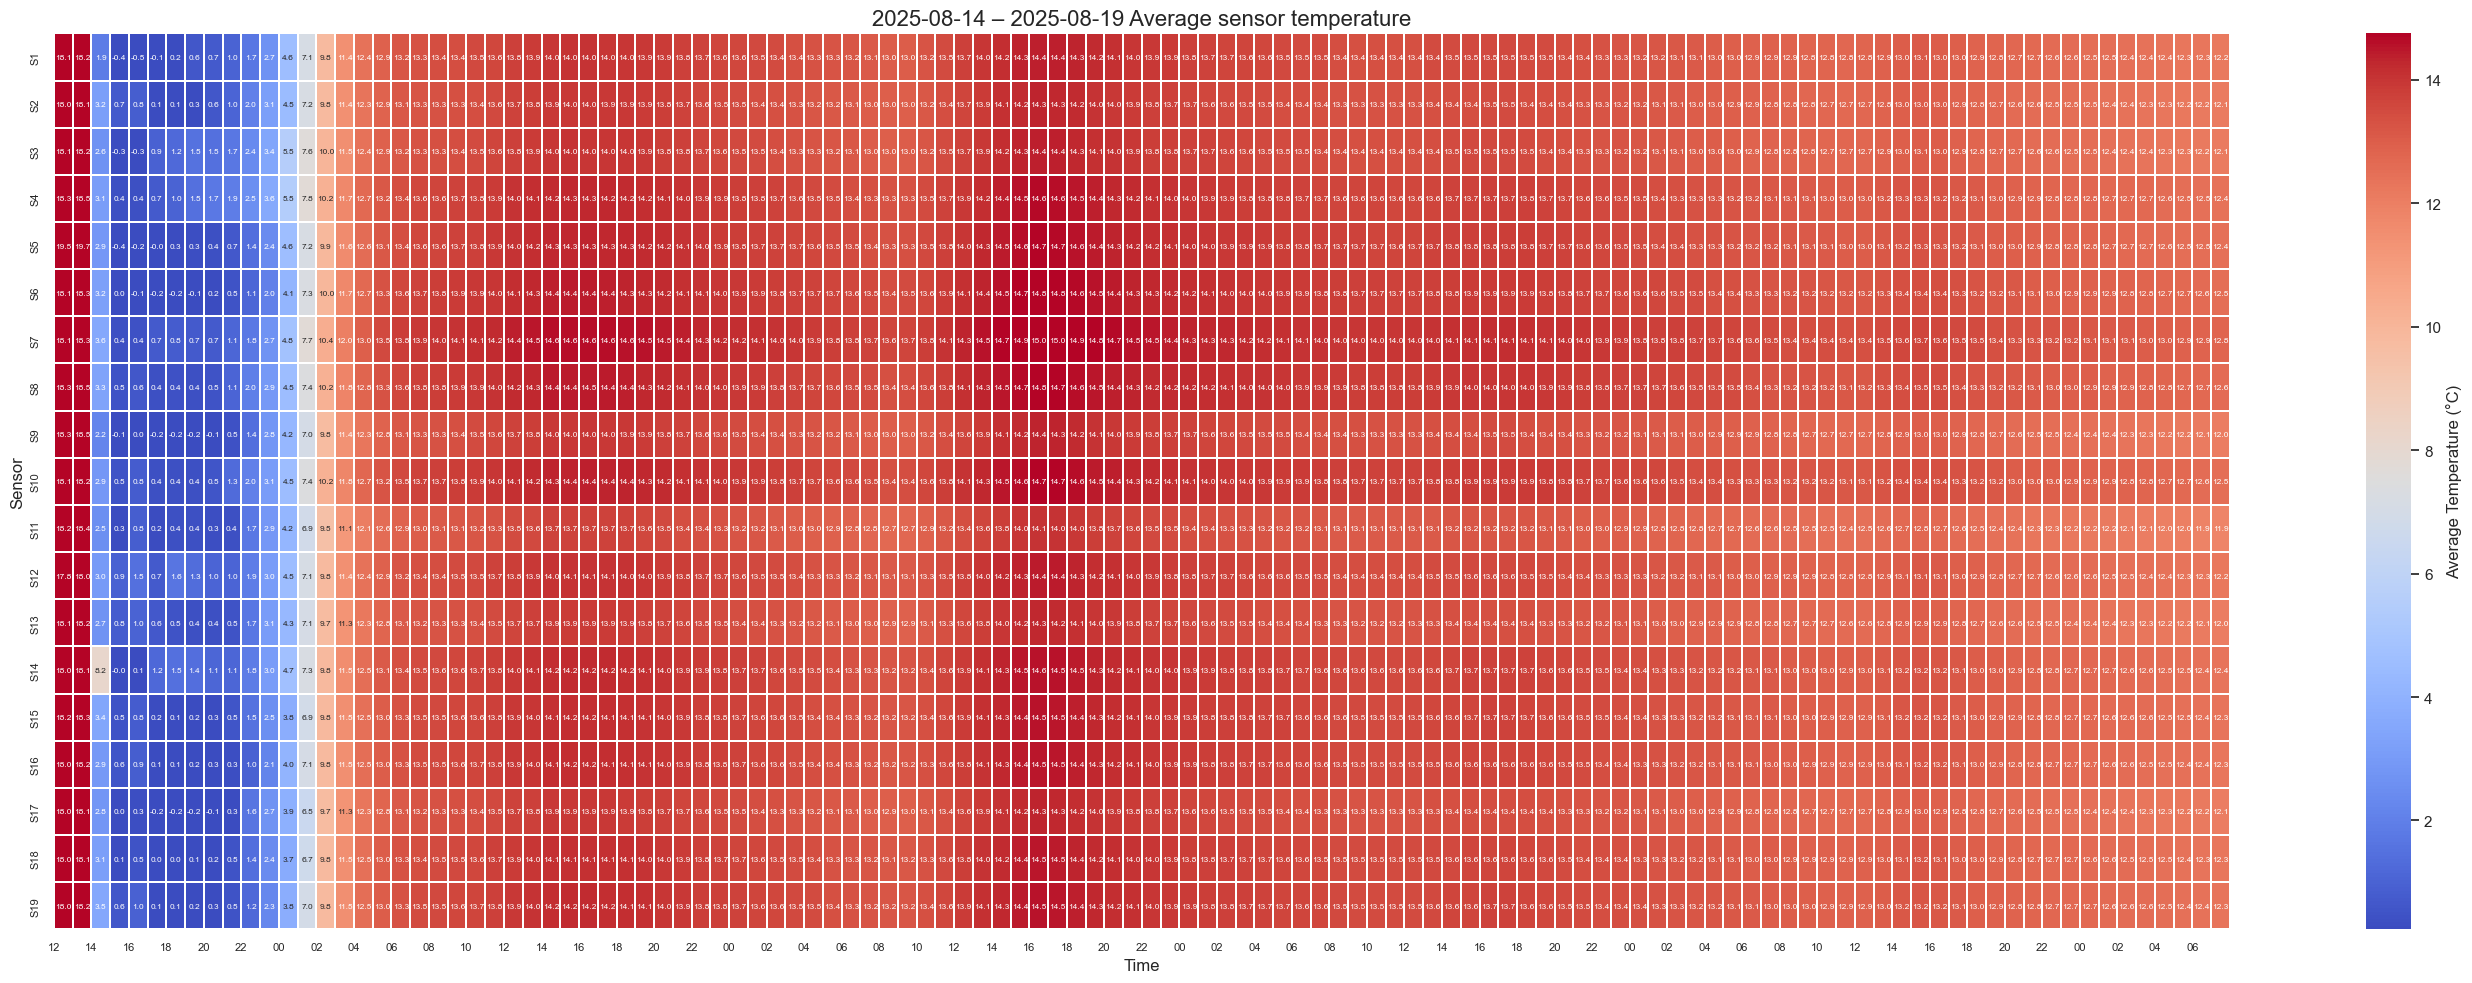

Heatmap global guardado en: fusion_plots_0814_0819/heatmap_2025_0814-0819.png


In [2]:
# Celda — Heatmap por día (promedio por hora y sensor con anotaciones simples)
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# ============== PARÁMETROS AJUSTABLES ==============
INPUT_CSV = 'Datalog_Filtered_log_R.csv'  # archivo de entrada

# 1) Menos columnas: subir intervalo temporal o subsamplear
RESAMPLE_RULE = '1h'      # '15min', '30min', '1h'
SUBSAMPLE_EVERY = None     # None o entero (p.ej., 4 = 1 de cada 4 columnas)

# 2) Anotaciones dentro de celdas (mostrar SOLO el promedio)
ANNOTATE = True            # True/False
CELL_TEXT_SIZE = 6         # tamaño de fuente de los números en celdas
LABEL_DECIMALS = 1         # decimales para °C cuando STANDARDIZE=False

# 3) Foco horario (filtra antes del resample)
BETWEEN_TIME = None        # None o ('10:00', '22:00')

# 4) Figura y ticks en X
FIGSIZE = (28, 10)
XTICK_EVERY_HOURS = 2      # ticks cada N horas
TICK_FONT_SIZE = 8

# 5) Small multiples: 1 heatmap por día además del global
PER_DAY_FIGS = True
PER_DAY_RESAMPLE = '30min'
PER_DAY_FIGSIZE = (18, 8)
PER_DAY_ANNOTATE = False   # mejor sin anotaciones por día para claridad

# 6) Estandarizar por sensor (z-score) para ver anomalías
STANDARDIZE = False        # True → z-score (center=0) y etiquetas en z-score (usa LABEL_DECIMALS para formateo)

# 7) Clipping de rango de color (evitar que outliers “aplanen” todo)
CLIP_BY_QUANTILES = (0.02, 0.98)  # None o (q_low, q_high)
VMIN_FIXED = None          # Ej. 10  (anula quantiles si no es None)
VMAX_FIXED = None          # Ej. 40

# 8) Suavizado (media móvil) tras el resample
SMOOTH_WINDOW = None       # None o ventana tipo '45min', '2h', etc.

# 9) Limitar sensores (ej. S1..S19)
MAX_SENSOR = 19            # None para no limitar, o un entero
# ===================================================


# ============== CARGA Y PREPARACIÓN ==============
df = pd.read_csv(INPUT_CSV)
df['Timestamp'] = pd.to_datetime(df['Date'] + ' ' + df['Time'])
df.set_index('Timestamp', inplace=True)

# Detectar columnas de sensores y ordenarlas
sensor_columns = sorted([c for c in df.columns if c.startswith('S')], key=lambda x: int(x[1:]))
if MAX_SENSOR is not None:
    sensor_columns = [c for c in sensor_columns if int(c[1:]) <= MAX_SENSOR]

# Coerción a numérico
for c in sensor_columns:
    df[c] = pd.to_numeric(df[c], errors='coerce')

# Foco horario
if BETWEEN_TIME is not None:
    start_t, end_t = BETWEEN_TIME
    df = df.between_time(start_t, end_t)

# ============== RESAMPLE Y (OPCIONAL) SUAVIZADO ==============
# PROMEDIO por hora (o regla indicada) → esto asegura que la celda representa SOLO el promedio hora×sensor
resampled_df = df[sensor_columns].resample(RESAMPLE_RULE).mean()

if SMOOTH_WINDOW:
    resampled_df = resampled_df.rolling(SMOOTH_WINDOW, min_periods=1).mean()

# Matriz para heatmap (filas = sensores, columnas = tiempo)
heatmap_data = resampled_df.transpose()

# (Opcional) Subsamplear columnas si todavía hay muchas
if SUBSAMPLE_EVERY and SUBSAMPLE_EVERY > 1:
    heatmap_data = heatmap_data.iloc[:, ::SUBSAMPLE_EVERY]

# ============== ESTANDARIZACIÓN / CLIPPING ==============
if STANDARDIZE:
    # z-score por sensor (fila)
    mu = heatmap_data.mean(axis=1)
    sigma = heatmap_data.std(axis=1).replace(0, np.nan)
    heatmap_plot = (heatmap_data - mu.values[:, None]) / sigma.values[:, None]
    cbar_label = 'z-score'
    vmin = vmax = None
    center = 0
    fmt_str = f'.{LABEL_DECIMALS}f'
else:
    heatmap_plot = heatmap_data
    cbar_label = 'Average Temperature (°C)'
    fmt_str = f'.{LABEL_DECIMALS}f'
    # Clipping por quantiles
    vmin = vmax = None
    if CLIP_BY_QUANTILES:
        flat = heatmap_plot.to_numpy().ravel()
        flat = flat[~np.isnan(flat)]
        if flat.size > 0:
            vmin = np.quantile(flat, CLIP_BY_QUANTILES[0])
            vmax = np.quantile(flat, CLIP_BY_QUANTILES[1])
    # Rango fijo opcional
    if VMIN_FIXED is not None:
        vmin = VMIN_FIXED
    if VMAX_FIXED is not None:
        vmax = VMAX_FIXED
    center = None

# ============== PLOTEO GLOBAL ==============
sns.set(context='notebook')
plt.figure(figsize=FIGSIZE)

ax = sns.heatmap(
    heatmap_plot,
    cmap='coolwarm',
    linewidths=.3,
    cbar_kws={'label': cbar_label},
    annot=ANNOTATE,               # ← números en celdas (solo el promedio)
    fmt=fmt_str,                  # ← formateo de las anotaciones (p.ej., .1f)
    annot_kws={'size': CELL_TEXT_SIZE},
    vmin=vmin,
    vmax=vmax,
    center=center
)

# Ticks en X cada N horas
cols = heatmap_plot.columns  # DatetimeIndex
if len(cols) > 0 and isinstance(cols, pd.DatetimeIndex):
    hourly_positions = [i for i, ts in enumerate(cols) if (ts.minute == 0 and (ts.hour % max(1, XTICK_EVERY_HOURS) == 0))]
    hourly_labels = [cols[i].strftime('%H') for i in hourly_positions]
    ax.set_xticks(hourly_positions)
    ax.set_xticklabels(hourly_labels, rotation=0, ha='center')

# Etiquetas y títulos + período detectado
if len(cols) > 0 and isinstance(cols, pd.DatetimeIndex):
    days = cols.normalize()
    dmin, dmax = days.min(), days.max()
    year_tag = dmin.strftime("%Y")
    period_tag_dash = f"{dmin:%m%d}-{dmax:%m%d}"   # MMDD-MMDD (para el nombre del archivo)
    period_tag_unders = f"{dmin:%m%d}_{dmax:%m%d}" # MMDD_MMDD (para la carpeta)
    title_date = dmin.strftime('%Y-%m-%d') if dmin == dmax else f'{dmin.strftime("%Y-%m-%d")} – {dmax.strftime("%Y-%m-%d")}'
else:
    year_tag = "unknown"
    period_tag_dash = "unknown"
    period_tag_unders = "unknown"
    title_date = ''

ax.set_title(f'{title_date} Average sensor temperature' + (' (z-score)' if STANDARDIZE else ''), fontsize=16)
ax.set_xlabel('Time', fontsize=12)
ax.set_ylabel('Sensor', fontsize=12)

ax.tick_params(axis='x', labelsize=TICK_FONT_SIZE)
ax.tick_params(axis='y', labelsize=TICK_FONT_SIZE)

plt.tight_layout()

# === NUEVO: Guardar en la misma carpeta del período (coincide con la otra celda)
OUT_DIR = f"fusion_plots_{period_tag_unders}"
os.makedirs(OUT_DIR, exist_ok=True)
out_file = os.path.join(OUT_DIR, f"heatmap_{year_tag}_{period_tag_dash}.png")

plt.savefig(out_file, dpi=300, bbox_inches='tight')
plt.show()

print(f"Heatmap global guardado en: {out_file}")

# ============== SMALL MULTIPLES (UNO POR DÍA) ==============
if PER_DAY_FIGS:
    for day, g in df.groupby(df.index.date):
        per_day = g[sensor_columns].resample(PER_DAY_RESAMPLE).mean()
        if SMOOTH_WINDOW:
            per_day = per_day.rolling(SMOOTH_WINDOW, min_periods=1).mean()
        hm = per_day.transpose()

        # Estandarización opcional por día
        if STANDARDIZE:
            mu_d = hm.mean(axis=1)
            sigma_d = hm.std(axis=1).replace(0, np.nan)
            hm_plot = (hm - mu_d.values[:, None]) / sigma_d.values[:, None]
            vmin_d = vmax_d = None
            center_d = 0
            cbar_label_d = 'z-score'
            fmt_day = f'.{LABEL_DECIMALS}f'
        else:
            hm_plot = hm
            # Clipping similar al global
            vmin_d = vmax_d = None
            if CLIP_BY_QUANTILES:
                flat_d = hm_plot.to_numpy().ravel()
                flat_d = flat_d[~np.isnan(flat_d)]
                if flat_d.size > 0:
                    vmin_d = np.quantile(flat_d, CLIP_BY_QUANTILES[0])
                    vmax_d = np.quantile(flat_d, CLIP_BY_QUANTILES[1])
            if VMIN_FIXED is not None:
                vmin_d = VMIN_FIXED
            if VMAX_FIXED is not None:
                vmax_d = VMAX_FIXED
            center_d = None
            cbar_label_d = 'Average Temperature (°C)'
            fmt_day = f'.{LABEL_DECIMALS}f'

        plt.figure(figsize=PER_DAY_FIGSIZE)
        ax2 = sns.heatmap(
            hm_plot,
            cmap='coolwarm',
            linewidths=.3,
            cbar_kws={'label': cbar_label_d},
            annot=PER_DAY_ANNOTATE,     # por día, default False para no saturar
            fmt=fmt_day,
            annot_kws={'size': CELL_TEXT_SIZE},
            vmin=vmin_d,
            vmax=vmax_d,
            center=center_d
        )

        # Ticks cada N horas
        cols_d = hm_plot.columns
        if len(cols_d) > 0 and isinstance(cols_d, pd.DatetimeIndex):
            pos = [i for i, ts in enumerate(cols_d) if (ts.minute == 0 and (ts.hour % max(1, XTICK_EVERY_HOURS) == 0))]
            lab = [cols_d[i].strftime('%H') for i in pos]
            ax2.set_xticks(pos)
            ax2.set_xticklabels(lab, rotation=0, ha='center')

        ax2.tick_params(axis='x', labelsize=TICK_FONT_SIZE)
        ax2.tick_params(axis='y', labelsize=TICK_FONT_SIZE)
        ax2.set_title(f'{day} Average sensor temperature' + (' (z-score)' if STANDARDIZE else ''), fontsize=14)
        ax2.set_xlabel('Time', fontsize=11)
        ax2.set_ylabel('Sensor', fontsize=11)

        plt.tight_layout()
        outname = f'Heatmap_{day}.png'
        plt.savefig(outname, dpi=300, bbox_inches='tight')
        plt.close()
